<a href="https://colab.research.google.com/github/dolmani38/Summary2/blob/main/korean_frame_token_0_1.0_gamma_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-abstractive summary method using adaptive discriminat GAN


#4. Implementation


## 4.1 기본 설정...

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install keybert
!pip install sentence-transformers==0.3.0
!pip install transformers==3.0.2

#!pip install sentence-transformers

     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 1.9MB 7.6MB/s 
     |████████████████████████████████| 3.2MB 37.0MB/s 
     |████████████████████████████████| 890kB 54.5MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.0-cp37-none-any.whl size=86754 sha256=558e17c46c55c9494637422caef31fd0f9e3ebd208e410c58b508f6830fdd6f9
  Stored in directory: /root/.cache/pip/wheels/b8/23/85/85d6a9a6c68f0625a1ecdaad903bb0a78df058c10cf74f9de4
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=5b5068cdd6b7d47fb5a2033a0277e7823a0a6c5ca3789077d58b8174cca0f7be
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses
     |████████████████████████████████| 778kB 7.8MB/s 
     |████████████████████████████████| 3.0MB 16.3MB/s 
     |████████████████████████████████| 1.2MB 35.1MB/s 
  Fo

In [3]:
import matplotlib.pyplot as plt
# set seeds for reproducability
from numpy.random import seed
seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [6]:
import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0
        self.back_filledLength = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))
        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        if filledLength > self.back_filledLength or percent == 100:
            print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
            # Print New Line on Complete
            if self.ite == self.total: 
                print()
        self.back_filledLength = filledLength    

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

##4.2 Grammar Discriminator Class

In [9]:
# coding=utf-8
# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Tokenization classes for KoBert model."""


import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [10]:
from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

import time
import random
import datetime

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    txt = txt.replace(' .','.')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

def collect_training_dataset_for_grammar_discriminator(sentences_dataset):

    sentences = []
    labels = []

    for txtss in sentences_dataset:
        txtss = clean_text(txtss)
        txts = txtss.strip().split('.')
        for txt in txts:  
            txt = txt.strip()
            if len(txt) > 40:
                #ko_grammar_dataset.append([txt,1])
                txt = txt.replace('.','')
                tf = random.choice([True,False])
                # 정상 또는 비정상 둘중에 하나만 데이터셋에 추가
                if (tf):
                    sentences.append(txt) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
                    labels.append(1)
                else:
                    sentences.append(shuffling(txt))
                    labels.append(0)

    return sentences,labels

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class Grammar_Discriminator:


    def __init__(self, pretraoned_kobert_model_name='monologg/kobert', input_dir=None):

        if input_dir is None:
            self.tokenizer = KoBertTokenizer.from_pretrained(pretraoned_kobert_model_name)
            self.discriminator = BertForSequenceClassification.from_pretrained(
                                    pretraoned_kobert_model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                    # You can increase this for multi-class tasks.   
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False, # Whether the model returns all hidden-states.
                                )            
        else:
            self.__load_model(input_dir)




    def set_dataset(self, sentences,labels):
        # Print the original sentence.
        print(' Original: ', sentences[0])

        # Print the sentence split into tokens.
        print('Tokenized: ', self.tokenizer.tokenize(sentences[0]))

        # Print the sentence mapped to token ids.
        print('Token IDs: ', self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(sentences[0])))   

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)

        # Print sentence 0, now as a list of IDs.
        print('Original: ', sentences[0])
        print('Token IDs:', input_ids[0])

        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        self.batch_size = 32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        self.train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = self.batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        self.validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = self.batch_size # Evaluate with this batch size.
                )        



    def train(self,epochs=4):
        # Tell pytorch to run this model on the GPU.
        self.discriminator.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.discriminator.named_parameters())

        print('The BERT model has {:} different named parameters.\n'.format(len(params)))

        print('==== Embedding Layer ====\n')

        for p in params[0:5]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== First Transformer ====\n')

        for p in params[5:21]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== Output Layer ====\n')

        for p in params[-4:]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))  

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW(self.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(self.train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.discriminator.train()

            # For each batch of training data...
            for step, batch in enumerate(self.train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.discriminator.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                loss, logits = self.discriminator(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(self.train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set.

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode--the dropout layers behave differently
            # during evaluation.
            self.discriminator.eval()

            # Tracking variables 
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in self.validation_dataloader:
                
                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using 
                # the `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        

                    # Forward pass, calculate logit predictions.
                    # token_type_ids is the same as the "segment ids", which 
                    # differentiates sentence 1 and 2 in 2-sentence tasks.
                    # The documentation for this `model` function is here: 
                    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                    # Get the "logits" output by the model. The "logits" are the output
                    # values prior to applying an activation function like the softmax.
                    (loss, logits) = self.discriminator(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                    
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches.
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                

            # Report the final accuracy for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(self.validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(self.validation_dataloader)
            
            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)
            
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
            

        return training_stats

    def save_model(self, output_dir = './model_save/'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.discriminator.module if hasattr(self.discriminator, 'module') else self.discriminator  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

    def __load_model(self, input_dir = './drive/MyDrive/Colab Notebooks/summary/en_grammar_check_model'):
        print('Loading BERT tokenizer...')
        self.tokenizer = BertTokenizer.from_pretrained(input_dir)
        self.discriminator = BertForSequenceClassification.from_pretrained(input_dir)

    def transfer_learning(self, sentences, train_for = True):
        
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
        
        if train_for:
            b_labels = torch.ones(len(sentences),dtype=torch.long).to(device)
        else:
            b_labels = torch.zeros(len(sentences),dtype=torch.long).to(device)
        #print(b_labels)
        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)    
        #if str(discriminator1.device) == 'cpu':
        #    pass
        #else:
        #    input_ids = input_ids.to(device)
        #    attention_masks = attention_masks.to(device)        

        loss, logits = self.discriminator(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_masks, 
                                labels=b_labels)
        #return torch.sigmoid(outputs[0][:,1])
        #return outputs[0][:,1]
        return loss, logits


In [11]:
urls = ['https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-ABC%20%EC%82%B4%EC%9D%B8%EC%82%AC%EA%B1%B4.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EA%B7%B8%EB%A6%AC%EA%B3%A0%20%EC%95%84%EB%AC%B4%EB%8F%84%20%EC%97%86%EC%97%88%EB%8B%A4.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%82%98%EC%9D%BC%EA%B0%95%EC%9D%98%20%EC%A3%BD%EC%9D%8C.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%A7%8C%EC%B0%AC%ED%9A%8C%EC%9D%98%2013%EC%9D%B8.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%A9%94%EC%86%8C%ED%8F%AC%ED%83%80%EB%AF%B8%EC%95%84%EC%9D%98%20%EC%A3%BD%EC%9D%8C.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%AA%A9%EC%82%AC%EA%B4%80%EC%82%B4%EC%9D%B8.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%B2%99%EC%96%B4%EB%A6%AC%20%EB%AA%A9%EA%B2%A9%EC%9E%90.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%B9%84%EB%B0%80%20%EC%84%9C%EB%A5%98%EB%A5%BC%20%EB%85%B8%EB%A0%A4%EB%9D%BC.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%8A%A4%ED%8E%98%EC%9D%B8%EA%B6%A4%EC%A7%9D%EC%9D%98%20%EB%B9%84%EB%B0%80.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%95%84%ED%8C%8C%ED%8A%B8%EC%97%90%20%EB%82%98%ED%83%80%EB%82%9C%20%EC%9A%94%EC%A0%95.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%95%A0%ED%81%AC%EB%A1%9C%EC%9D%B4%EB%93%9C%20%EC%82%B4%EC%9D%B8%20%EC%82%AC%EA%B1%B4.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%98%88%EA%B3%A0%20%EC%82%B4%EC%9D%B8.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%A5%90%EB%8D%AB.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%BB%A4%ED%8A%BC.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%ED%81%AC%EB%A6%AC%EC%8A%A4%EB%A7%88%EC%8A%A4%20%ED%91%B8%EB%94%A9%EC%9D%98%20%EB%AA%A8%ED%97%98.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%ED%91%B8%EB%A5%B8%EC%97%B4%EC%B0%A8%EC%9D%98%EC%A3%BD%EC%9D%8C.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%ED%99%94%EC%9A%94%EC%9D%BC%20%ED%81%B4%EB%9F%BD%EC%9D%98%20%EC%82%B4%EC%9D%B8.txt']

ko_sentences_dataset = []
for url in urls:
    raw_text = urllib.request.urlopen(url).read().decode('utf-8')
    ko_sentences_dataset += nltk.sent_tokenize(clean_text(raw_text))
    

In [12]:
len(ko_sentences_dataset)

95889

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/summary/korean_sentences.csv')

In [ ]:
ko_sentences_dataset += list(df['sentence'])

In [ ]:
len(ko_sentences_dataset)

503444

In [14]:
use_pretrained_model = True

if use_pretrained_model:
    #g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/model_save')
    g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/ko_grammar_model')
else:
    sentences,labels = collect_training_dataset_for_grammar_discriminator(ko_sentences_dataset)
    print(len(sentences))
    g_discriminator = Grammar_Discriminator()
    g_discriminator.set_dataset(sentences,labels)
    g_discriminator.train(epochs=1)
    g_discriminator.save_model(output_dir='/content/drive/MyDrive/Colab Notebooks/summary/ko_grammar_model')

Loading BERT tokenizer...


In [ ]:
if False: ## 추가적인 fine-tuning
    #sentences,labels = collect_training_dataset_for_grammar_discriminator(ko_sentences_dataset)
    #print(len(sentences))
    #g_discriminator = Grammar_Discriminator()
    #g_discriminator.set_dataset(sentences,labels)
    g_discriminator.train(epochs=1)
    g_discriminator.save_model()

##4.3 Static similarity discriminator class

In [15]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import scipy


class Similarity_Discriminator:
    '''
    _instance = None
    _embedder = None
    def __new__(cls,pre_trained_model_name='stsb-roberta-large'):
        if cls._instance is None:
            print('Creating Similarity_Discriminator object')
            cls._instance = super(Similarity_Discriminator, cls).__new__(cls)
            # Put any initialization here.
            cls._embedder = SentenceTransformer(pre_trained_model_name)
        return cls._instance

    '''

    def __init__(self,pre_trained_model_name='xlm-r-large-en-ko-nli-ststb'):
        print('Creating Similarity_Discriminator object')
        # Put any initialization here.
        self._embedder = SentenceTransformer(pre_trained_model_name)  
        #self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    def encode(self,texts):
        return self._embedder.encode(texts,show_progress_bar=False)

    def similarity(self, query_text, org_text_emb):
        queries = nltk.sent_tokenize(query_text)
        query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #print(queries)
        #print(org_text_emb)
        
        if len(query_embeddings) == 0:
            return 0.0

        cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_text_emb, "cosine")
        similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))
        '''
        for query, query_embedding in zip(queries, query_embeddings):
            distances = scipy.spatial.distance.cdist([query_embedding], [org_text_emb], "cosine")[0]
            results = zip(range(len(distances)), distances)
            for idx, distance in results:
                scores.append(1-distance)
        '''
        return similarity_score  
 

###4.3.1 한국어 문장 유사도 pre-trained model 적용

In [16]:
s_discriminator = Similarity_Discriminator()
#s_discriminator = Similarity_Discriminator()

Creating Similarity_Discriminator object


100%|██████████| 1.80G/1.80G [01:30<00:00, 19.9MB/s]


##4.4 Document source class

###4.4.1 keyBERT를 위한 pre-trained model의 적재

In [ ]:
#!pip install keybert

In [ ]:
#from keybert import KeyBERT
#key_model = KeyBERT('distilbert-base-nli-mean-tokens')

###4.4.2 frame term 추출을 위한 source class 구현

In [17]:


class Source:

    def __init__(self,org_text):
        self.org_text = org_text

    def __crean_text(self, txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()


    def extract_keywords(self,s_discriminator,key_model,comp_rate=0.2):
        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}
        index_table = {}
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')
        '''
        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        '''
        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        # story에 지배적인 word를 찾는다.
        # 먼저 word의 강세 분석
        for filter in word_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #print('\n part_sen:',part_sen)
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                word_weights[t] += score 

        # story의 강세 분석
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                story_weights[t] += score

        #각각의 peak를 산출
        word_peaks, _ = find_peaks(word_weights, height=0)
        story_peaks, _ = find_peaks(story_weights, height=0)

        #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
        #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
        #이를 통해 story에 대한 word를 최대한 추출 한다.

        dup_order = []
        for i in range(self.org_source_length):
            #lst = ""
            if (i in word_peaks) and (i in story_peaks):
                if terms[i].endswith('.'):
                    pass
                else:
                    dup_order.append(i)
                    
        # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
        print('Negative tokens:',terms[dup_order])
        '''

        top_n = int(len(self.term_table) * comp_rate)

        self.story_peaks = []
        keywords = key_model.extract_keywords(self.org_text,top_n=top_n)
        #print('keywords len',len(keywords))
        #print('keywords',keywords)
        for keyword,p in keywords:
            for k in self.term_table.keys():
                if self.term_table[k] == keyword: # and k not in dup_order:
                    self.story_peaks.append(k)

        self.story_peaks.append(len(self.term_table)-2)
        self.story_peaks = np.sort(np.asarray(self.story_peaks))
        print('story_peaks:',self.story_peaks)
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame tokens:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similarity(self.frame_text.strip(),self.org_text_emb)}')    

    def set_key_rate(self,s_discriminator,comp_rate=0.2):
        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        top_n = int(len(self.term_table) * comp_rate)
        #print('top_n',top_n)
        self.story_peaks = [i+1 for i in range(top_n)]

    def analysis_frame_terms(self,s_discriminator,story_filters=np.array([[0,1],[0,1,2],[0,1,2,3]]),peak_base_line = 0.0,comp_rate=0.2,except_key=True,display=False):

        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')
        '''

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)

        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        if except_key:
            # story에 지배적인 word를 찾는다.
            # 먼저 word의 강세 분석
            for filter in word_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='Frame token scan:')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    word_weights[t] += score 

            # story의 강세 분석
            for filter in story_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='Frame token scan:')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    story_weights[t] += score

            #각각의 peak를 산출
            word_peaks, _ = find_peaks(word_weights, height=0)
            story_peaks, _ = find_peaks(story_weights, height=0)

            #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
            #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
            #이를 통해 story에 대한 word를 최대한 추출 한다.

            dup_order = []
            for i in range(self.org_source_length):
                #lst = ""
                if (i in word_peaks) and (i in story_peaks):
                    if terms[i].endswith('.'):
                        pass
                    else:
                        dup_order.append(i)
                        
            # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
            print('Negative tokens:',terms[dup_order])
            if except_key:
                terms[dup_order] = '---'
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code         Token      ')
        print('')
        for index, word in zip(range(len(terms)),terms):
            print( f'  {str(index).ljust(8)}    {word}')
        print('---------------------------------------------')
        '''
        self.story_weights = np.zeros(self.org_source_length,)
        # 그리고 다시 story 분석 스캔
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #part_sen = part_sen.replace('소녀','---')
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                self.story_weights[t] += score        


        # base line
        base_line = peak_base_line
        # 다시 peak 추출
        story_peaks, _ = find_peaks(self.story_weights, height=base_line)

        top_n = int(len(self.term_table) * comp_rate)

        if len(story_peaks) > top_n:
            peak_dict = {}
            for i,peak in zip(range(len(story_peaks)),story_peaks):
                peak_dict[peak] = self.story_weights[peak]
            #print(peak_dict)
            peaks = sorted(peak_dict, key=peak_dict.get, reverse=True)
            #print(peaks)
            peaks = peaks[:top_n]
            #print(peaks)
            peaks.sort()
            story_peaks = peaks
            #print(story_peaks)

        #print('top_n:',top_n,'story_peaks:',len(story_peaks))
        #print(story_peaks)
        
        self.story_peaks = np.append(story_peaks,len(story_weights)-2)
        #print(self.story_peaks)
        # story density 표출
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(self.story_weights)
            plt.plot(self.story_peaks, self.story_weights[self.story_peaks], "x")
            plt.plot(np.zeros_like(self.story_weights)+base_line, "--", color="gray")
            plt.show() 
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame tokens:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similarity(self.frame_text.strip(),self.org_text_emb)}')      
        ''' 
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
   
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Score        Token              ')
        print('')
        for k in self.term_table.keys(): 
            print( f'  {str(k).ljust(5)}   {str(round(self.story_weights[k],4)).ljust(8)}  {self.term_table[k]}')

        print('---------------------------------------------') 
        '''
    def get_org_sample(self, num):
        return self.org_sentences[np.random.choice(len(self.org_sentences), num)]

    def get_source_embedded_code(self):
        return self.org_text_emb

##4.5 Generator class

In [18]:
from functools import reduce

class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*2, input_size*3),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*3, input_size*3),
            nn.LeakyReLU(0.2),            
            nn.Linear(input_size*3, input_size*2),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*2, input_size),
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )
    '''
    def forward(self, x, story_peaks, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y_[:,story_peaks] += bias
        y_ = nn.Sigmoid()(y_)
        #reduce(torch.add, [y_,bias]) / 2
        return y_
    '''

    
    def forward(self, x, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y = torch.add(y_,bias)
        #y = nn.Sigmoid()(y)

        return y, y_

    '''    
    def forward(self, x):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        #y = torch.add(y_,bias)
        y = nn.Sigmoid()(y_)

        return y, y_    
    '''    

##4.6 Summarizer class (GAN training)

In [19]:
import random
import math
import numpy as np
from scipy.special import expit

class SAM_Summarizer:

    def __init__(self,g_discriminator,s_discriminator):
        self.g_discriminator = g_discriminator
        self.s_discriminator = s_discriminator
        self.m = nn.Sigmoid()

    def ready(self,source):
        self.source = source  
        #self.source.analysis_frame_terms(self.s_discriminator)
        self.generator = Generator(input_size=self.source.org_source_length)

        return self

    def summarize(self,epochs=10,batch_size=2,frame_expansion_ratio = 0.8,init_bias = 1.0,learning_rate=2e-4, display = False):
        self.frame_expansion_ratio = frame_expansion_ratio
        history = self.__train(epochs,batch_size,init_bias,learning_rate,display)
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(history['gen_g_loss'],label='generator grammar loss')
            plt.plot(history['gen_s_loss'],label='generator similarity loss')
            #if 'dis_loss' in history:
            #    plt.plot(history['dis_loss'],label='discriminator grammar loss')
            plt.legend()
            plt.show()

        return self

    # text의 생성 for torch
    def __text_gen2(self, noise, gen_length):
        gtext = []
        sorted_noise, i = torch.sort(noise, descending=True)
        order, i = torch.sort(i[:gen_length], descending=False)
        #print(len(order))
        assert len(order) == gen_length
        order = order.cpu().detach().numpy()
        for k in order:
            gtext.append((self.source.term_table[k],k))
        return gtext

    def __discrete_gradient(self,weights,gen_length,beta,use_gpu=False, verbose=0):
        fake_gen_out = torch.zeros(weights.shape).to(device)
        fake_sim_out = torch.zeros(weights.shape).to(device)

        real_text = self.source.get_org_sample(weights.shape[0])
        fake_outs = []
        real_outs = []
        apply_order = []
        for i, noise in enumerate(weights):
            gtext = self.__text_gen2(noise,gen_length)
            tw = ""
            tk = []
            fake_scores = []
            for (w,k) in gtext:
                tw += w + ' '
                tk.append(k)
                if w.endswith('.'):
                    fake_outs.append(tw.strip())
                    real_outs.append(real_text[i])
                    apply_order.append((i,tk))
                    tw = ""
                    tk = []
                    
            if len(tk) > 0:
                fake_outs.append(tw.strip())
                real_outs.append(real_text[i])
                apply_order.append((i,tk))

        D_z_loss, fake_gmr_out=self.g_discriminator.transfer_learning(fake_outs,train_for = False)
        D_x_loss, real_gmr_out=self.g_discriminator.transfer_learning(real_outs,train_for = True)   # not use of 'real_gmr_out'

        f_sim_out = []
        for fake_text in fake_outs:
            f_sim_out.append(self.s_discriminator.similarity(fake_text,self.source.org_text_emb))

        #if use_gpu:
        #    apply_order = torch.FloatTensor(apply_order).to(device)  
        
        #print(fake_dis_out)
        
        for j, (i,tk) in enumerate(apply_order):
            #fake_gen_out[i,tk] += fake_dis_out[j].numpy() --> 이거는 tf 용...
            #fake_gen_out[i,tk] += fake_dis_out[j] #.cpu().detach().numpy()
            # 
            try:
                #print('fake_gmr_out:',fake_gmr_out[j,1])
                #print('real_gmr_out:',real_gmr_out[j,1])
                #fake_gen_out[i,tk] += torch.sigmoid(fake_gmr_out[j,1])

                fake_gen_out[i,tk] += torch.tanh( fake_gmr_out[j,1])
                fake_sim_out[i,tk] += f_sim_out[j] * beta
                
            except Exception as ex:
                print(j,i,tk)
                print(fake_gmr_out)
                raise ex

        return fake_gen_out, fake_sim_out, D_z_loss, D_x_loss


    def __train(self, epochs=10,batch_size=10,init_bias = 1.0,learning_rate=2e-4, display = False):
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        #generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        # This method returns a helper function to compute cross entropy loss
        #cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Set the seed value all over the place to make this reproducible.
        seed_val = 10

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        
        criterion = nn.BCELoss()
        #D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        G_opt = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        D1_opt = AdamW(self.g_discriminator.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        pb = ProgressBar(epochs,prefix='Train...')
        gen_gmr_loss_history = []
        gen_sim_loss_history = []
        dis_loss_history = []    

        #model 들은 cuda로 보낸다.
        self.g_discriminator.discriminator.to(device)
        self.g_discriminator.discriminator.eval() # 학습하지 않는다...

        self.generator.to(device)       
        self.generator.train()

        self.bias_w = init_bias
        initial_bias = 0
        G_s_loss = torch.tensor(0)
        G_g_loss = torch.tensor(0)

        beta = 1

        for i in range(epochs):
            '''
            noise = torch.randn(batch_size,self.source.org_source_length).to(device)
            bias = torch.zeros_like(noise).to(device)
            bias[:,self.source.story_peaks] += self.bias_w 
            with torch.no_grad():        
                sw, sw0 = self.generator(noise,bias)

            self.g_discriminator.discriminator.train()          #discriminator는 evaluation 모드로 전환
            fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length)
            
            D_loss = D_x_loss + D_z_loss      

            self.g_discriminator.discriminator.zero_grad()
            D_loss.backward()
            D1_opt.step()
            self.g_discriminator.discriminator.eval()
            '''
            if True:
                noise = torch.randn(batch_size,self.source.org_source_length).to(device)
                bias = torch.zeros_like(noise).to(device)
                bias[:,self.source.story_peaks] += self.bias_w

                sw, sw0 = self.generator(noise,bias)

                with torch.no_grad():                
                    fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length,beta)
                
                '''
                if int(i/10)%2 == 0:  # grammar와 similarity를 각각 한번씩 교대로 학습한다?
                    sw1 = sw * fake_sim_out
                    G_s_loss = -torch.mean(sw1)
                    G_loss = G_s_loss    
                else: #if i%2 == 1:
                    sw1 = sw * fake_gmr_out
                    G_g_loss = -torch.mean(sw1)
                    G_loss = G_g_loss
                '''
                sw1 = sw * fake_sim_out
                G_s_loss = -torch.mean(sw1)
                sw2 = sw * fake_gmr_out
                G_g_loss = -torch.mean(sw2)

                G_loss =  G_g_loss + G_s_loss
                
                self.generator.zero_grad()
                G_loss.backward()
                #print('backward:')
                G_opt.step()
                #self.generator.eval()
            #print('step:')
            gen_gmr_loss_history.append(G_g_loss.cpu().detach().numpy())
            gen_sim_loss_history.append(G_s_loss.cpu().detach().numpy())
            #dis_loss_history.append(D_loss.cpu().detach().numpy())

            beta = self.m(-(G_g_loss-G_s_loss)*10) * 4

            if math.isnan(beta) or beta > 5:
                beta = 1

            pb.printProgress(+1,f'{i+1}/{epochs} epochs, beta:{beta} Generator / grammar loss:{G_g_loss}   similarity loss:{G_s_loss}') #,   Discriminator grammar_loss:{D_loss}        ')
            
            
        self.generator.eval()
        self.g_discriminator.discriminator.eval()
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(sw0[0].cpu().detach().numpy(),label='before activation weights')
            plt.plot(sw[0].cpu().detach().numpy(),label='after activation weights')
            plt.plot(bias[0].cpu().detach().numpy(),label='bias weights')
            plt.legend()        
            plt.show()

        return  {'gen_g_loss':gen_gmr_loss_history,'gen_s_loss':gen_sim_loss_history} #,'dis_loss':dis_loss_history }

    def get_summary(self, count):
        texts = []
        self.generator.cpu()
        self.generator.eval()
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        #bias = torch.randn(1,self.source.org_source_length)
        bias[:,self.source.story_peaks] += self.bias_w #self.last_bias_max.cpu().detach().numpy()
        #bias = 0
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
            #sw,sw0 = self.generator(noise)

        for noise in sw:
            gtext = self.__text_gen2(noise,gen_length)
            text = ' '.join([w for (w,k) in gtext])
            #print(text)
            texts.append(text)
        return texts

#5. Experiment

## 비교 대상 요약 알고리즘 준비

In [20]:
def similarity(query_text, org_text):
    sentences = nltk.sent_tokenize(org_text)
    #print("Num sentences:", len(sentences))
    querys = nltk.sent_tokenize(query_text)
    #print("Num querys:", len(querys))

    #Compute the sentence embeddings
    org_embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)
    query_embeddings = s_discriminator._embedder.encode(querys,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_embeddings, "cosine")
    similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))

    return similarity_score

def grammarity(text):
    
    input_ids = []
    attention_masks = []

    sentences = np.asarray(nltk.sent_tokenize(text))
    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = g_discriminator.tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            truncation = True,
                       )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)
    g_discriminator.discriminator.to(device)
    #if str(discriminator1.device) == 'cpu':
    #    pass
    #else:
    #    input_ids = input_ids.to(device)
    #    attention_masks = attention_masks.to(device)        

    with torch.no_grad():        
        outputs = g_discriminator.discriminator(input_ids, 
                               token_type_ids=None, 
                               attention_mask=attention_masks)
    #return torch.sigmoid(outputs[0][:,1])
    return torch.mean(outputs[0][:,1]).detach().cpu().numpy()
    #return outputs

In [21]:
import pandas as pd
import numpy as np

def evaluate(method_name, text, g_summ, org_text_1,org_text_2,org_text_3):
    result = {}
    result['method'] = [method_name]
    org_text = org_text_1 + ' ' + org_text_2 + ' ' + org_text_3
    result['comp ratio'] = [len(text)/len(org_text)]
    result['intro'] = [similarity(text,org_text_1)]
    result['body'] = [similarity(text,org_text_2)]
    result['ending'] = [similarity(text,org_text_3)]
    result['var'] = [np.var([result['intro'][0],result['body'][0],result['ending'][0]])]
    result['total'] = [similarity(text,org_text)]
    result['grammar'] = [np.tanh(float(grammarity(text)))]
    #scores = scorer.score(g_summ,text)
    #result['R1'] = [scores['rouge1'].fmeasure]
    #result['R2'] = [scores['rouge2'].fmeasure]
    #result['RL'] = [scores['rougeL'].fmeasure]
    return pd.DataFrame(result),result

In [22]:
"""
LexRank implementation
Source: https://github.com/crabcamp/lexrank/tree/dev
"""

import numpy as np
from scipy.sparse.csgraph import connected_components

def degree_centrality_scores(
    similarity_matrix,
    threshold=None,
    increase_power=True,
):
    if not (
        threshold is None
        or isinstance(threshold, float)
        and 0 <= threshold < 1
    ):
        raise ValueError(
            '\'threshold\' should be a floating-point number '
            'from the interval [0, 1) or None',
        )

    if threshold is None:
        markov_matrix = create_markov_matrix(similarity_matrix)

    else:
        markov_matrix = create_markov_matrix_discrete(
            similarity_matrix,
            threshold,
        )

    scores = stationary_distribution(
        markov_matrix,
        increase_power=increase_power,
        normalized=False,
    )

    return scores


def _power_method(transition_matrix, increase_power=True):
    eigenvector = np.ones(len(transition_matrix))

    if len(eigenvector) == 1:
        return eigenvector

    transition = transition_matrix.transpose()

    while True:
        eigenvector_next = np.dot(transition, eigenvector)

        if np.allclose(eigenvector_next, eigenvector):
            return eigenvector_next

        eigenvector = eigenvector_next

        if increase_power:
            transition = np.dot(transition, transition)


def connected_nodes(matrix):
    _, labels = connected_components(matrix)

    groups = []

    for tag in np.unique(labels):
        group = np.where(labels == tag)[0]
        groups.append(group)

    return groups


def create_markov_matrix(weights_matrix):
    n_1, n_2 = weights_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'weights_matrix\' should be square')

    row_sum = weights_matrix.sum(axis=1, keepdims=True)

    return weights_matrix / row_sum


def create_markov_matrix_discrete(weights_matrix, threshold):
    discrete_weights_matrix = np.zeros(weights_matrix.shape)
    ixs = np.where(weights_matrix >= threshold)
    discrete_weights_matrix[ixs] = 1

    return create_markov_matrix(discrete_weights_matrix)


def graph_nodes_clusters(transition_matrix, increase_power=True):
    clusters = connected_nodes(transition_matrix)
    clusters.sort(key=len, reverse=True)

    centroid_scores = []

    for group in clusters:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        centroid_scores.append(eigenvector / len(group))

    return clusters, centroid_scores


def stationary_distribution(
    transition_matrix,
    increase_power=True,
    normalized=True,
):
    n_1, n_2 = transition_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'transition_matrix\' should be square')

    distribution = np.zeros(n_1)

    grouped_indices = connected_nodes(transition_matrix)

    for group in grouped_indices:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        distribution[group] = eigenvector

    if normalized:
        distribution /= n_1

    return distribution


* Hands-on Guide To Extractive Text Summarization With BERTSum<br>
https://analyticsindiamag.com/hands-on-guide-to-extractive-text-summarization-with-bertsum/ <br>
https://pypi.org/project/bert-extractive-summarizer/

In [23]:
!pip install bert-extractive-summarizer

In [24]:
def bert_lexrank_sum(g_summ,org_text,n_top=8):
    input_text = org_text[0] + org_text[1] + org_text[2]
    #Split the document into sentences
    sentences = nltk.sent_tokenize(input_text)
    #print("Num sentences:", len(sentences))

    #Compute the sentence embeddings
    embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(embeddings, embeddings, "cosine")
    #util.pytorch_cos_sim(embeddings, embeddings).numpy()
    #print(cos_scores)
    #Compute the centrality for each sentence
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)

    #We argsort so that the first element is the sentence with the highest score
    most_central_sentence_indices = np.argsort(-centrality_scores)

    #Print the 5 sentences with the highest scores
    summary_text = ""
    for idx in most_central_sentence_indices[0:n_top]:
        summary_text += sentences[idx].strip()
    print('bert_lexrank summary:')
    print(summary_text)
    print('-'*50)
    df,arr = evaluate('BERT+LexRank',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr


In [25]:

from summarizer import Summarizer


model1 = Summarizer()


def besm(g_summ,org_text):
    result = model1(org_text[0] + org_text[1] + org_text[2], num_sentences=5)
    summary_text = "".join(result)
    print('besm summary:')
    print(summary_text)
    print('-'*50)    
    df,arr = evaluate('BESM',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

In [26]:
from transformers import AutoConfig,AutoTokenizer,AutoModel

SQUAD_MODEL = "monologg/kobert"

#SQUAD_MODEL = "bert-large-uncased"
# Load model, model config and tokenizer via Transformers
custom_config = AutoConfig.from_pretrained(SQUAD_MODEL)
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained(SQUAD_MODEL)
custom_model = AutoModel.from_pretrained(SQUAD_MODEL, config=custom_config)

model2 = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

def besm_bert(g_summ,org_text):
    result = model2(org_text[0].lower() + org_text[1].lower() + org_text[2].lower(), num_sentences=5)
    summary_text = "".join(result)
    print('besm_bert summary:')
    print(summary_text)
    print('-'*50)      
    df,arr = evaluate('BESM+kobert',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

In [27]:
org_text_1 = """
옛날 어느 집에 귀여운 여자 아기가 태어났어요.
아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요.
그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요.
소녀의 아버지는 홀로 남은 소녀가 걱정되었어요.
그래서 얼마 후 새어머니를 맞이했어요.
새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요.
그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요.
새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요.
그런데 이번에는 아버지마저 돌아가셨어요.
소녀는 하녀처럼 하루 종일 쓸고, 닦고, 집안일을 도맡아 했어요.
해도 해도 끝이 없는 집안일이 힘들어 지칠때면
난롯가에 앉아서 잠시 쉬곤 했지요.
"""

org_text_2 = """
어느 날, 왕궁에서 무도회가 열렸어요.
신데렐라의 집에도 초대장이 왔어요.
새어머니는 언니들을 데리고 무도회장으로 떠났어요.
신데렐라도 무도회에 가고 싶었어요.
혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요.
신데렐라, 너도 무도회에 가고 싶니?
신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요.
내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리, 도마뱀을 구해 오렴.
마법사 할머니가 주문을 외웠어요.
그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금 마차로 변했어요.
이번에는 생쥐와 도마뱀을 건드렸어요.
그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다.
신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요.
신데렐라, 발을 내밀어 보거라.
할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요.
신데렐라, 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지?
왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요.
왕자님은 무도회장에 모인 다른 아가씨들은 쳐다보지도 않고,신데렐라하고만 춤을 추었어요.
신데렐라는 왕자님과 춤을 추느라 시간 가는 줄도 몰랐어요.
땡, 땡, 땡...... 벽시계가 열두 시를 알리는 소리에 신데렐라는 화들짝 놀랐어요.
신데렐라가 허둥지둥 왕궁을 빠져나가는데,
유리 구두 한 짝이 벗겨졌어요.
하지만 구두를 주울 틈이 없었어요.
신데렐라를 뛰쫓아오던 왕자님은 층계에서 유리 구두 한 짝을 주웠어요.
왕자님은 유리 구두를 가지고 임금님께 가서 말했어요.
이 유리 구두의 주인과 결혼하겠어요.
"""

org_text_3 = """
그래서 신하들은 유리 구두의 주인을 찾아 온 나라를 돌아다녔어요.
언니들은 발을 오므려도 보고, 구두를 늘려도 보았지만 한눈에 보기에도 유리 구두는 너무 작았어요.
그때, 신데렐라가 조용히 다가와 말했어요.
저도 한번 신어 볼 수 있나요?
신데렐라는 신하게 건넨 유리 구두를 신었어요,
유리 구두는 신데렐라의 발에 꼭 맞았어요.
신하들은 신데렐라를 왕궁으로 데리고 갔어요.
그 뒤 신데렐라는 왕자님과 결혼하여 오래오래 행복하게 살았대요.
"""

In [28]:
urls = ['https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-ABC%20%EC%82%B4%EC%9D%B8%EC%82%AC%EA%B1%B4.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EA%B7%B8%EB%A6%AC%EA%B3%A0%20%EC%95%84%EB%AC%B4%EB%8F%84%20%EC%97%86%EC%97%88%EB%8B%A4.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%82%98%EC%9D%BC%EA%B0%95%EC%9D%98%20%EC%A3%BD%EC%9D%8C.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%A7%8C%EC%B0%AC%ED%9A%8C%EC%9D%98%2013%EC%9D%B8.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%A9%94%EC%86%8C%ED%8F%AC%ED%83%80%EB%AF%B8%EC%95%84%EC%9D%98%20%EC%A3%BD%EC%9D%8C.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%AA%A9%EC%82%AC%EA%B4%80%EC%82%B4%EC%9D%B8.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%B2%99%EC%96%B4%EB%A6%AC%20%EB%AA%A9%EA%B2%A9%EC%9E%90.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EB%B9%84%EB%B0%80%20%EC%84%9C%EB%A5%98%EB%A5%BC%20%EB%85%B8%EB%A0%A4%EB%9D%BC.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%8A%A4%ED%8E%98%EC%9D%B8%EA%B6%A4%EC%A7%9D%EC%9D%98%20%EB%B9%84%EB%B0%80.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%95%84%ED%8C%8C%ED%8A%B8%EC%97%90%20%EB%82%98%ED%83%80%EB%82%9C%20%EC%9A%94%EC%A0%95.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%95%A0%ED%81%AC%EB%A1%9C%EC%9D%B4%EB%93%9C%20%EC%82%B4%EC%9D%B8%20%EC%82%AC%EA%B1%B4.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%98%88%EA%B3%A0%20%EC%82%B4%EC%9D%B8.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%A5%90%EB%8D%AB.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%EC%BB%A4%ED%8A%BC.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%ED%81%AC%EB%A6%AC%EC%8A%A4%EB%A7%88%EC%8A%A4%20%ED%91%B8%EB%94%A9%EC%9D%98%20%EB%AA%A8%ED%97%98.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%ED%91%B8%EB%A5%B8%EC%97%B4%EC%B0%A8%EC%9D%98%EC%A3%BD%EC%9D%8C.txt',
        'https://raw.githubusercontent.com/dolmani38/Summary/master/data/%EC%95%A0%EA%B1%B0%EC%84%9C%ED%81%AC%EB%A6%AC%EC%8A%A4%ED%8B%B0-%ED%99%94%EC%9A%94%EC%9D%BC%20%ED%81%B4%EB%9F%BD%EC%9D%98%20%EC%82%B4%EC%9D%B8.txt']

ko_sentences_dataset2 = []
for url in urls:
    raw_text = urllib.request.urlopen(url).read().decode('utf-8')
    ko_sentences_dataset2 += nltk.sent_tokenize(clean_text(raw_text))

In [29]:
document = []
offset = 0
document += [[org_text_1,org_text_2,org_text_3]]
while (offset < len(ko_sentences_dataset2)):
    intro_cnt = random.choice([5,8,10,13])
    body_cnt = random.choice([10,15,18,20,25])
    conclu_cnt = random.choice([5,8,10,13])
    intro = ' '.join(ko_sentences_dataset[offset:offset+intro_cnt])
    body = ' '.join(ko_sentences_dataset[offset+intro_cnt:offset+intro_cnt+body_cnt])
    conclu = ' '.join(ko_sentences_dataset[offset+intro_cnt+body_cnt:offset+intro_cnt+body_cnt+conclu_cnt])
    offset = offset+intro_cnt+body_cnt+conclu_cnt
    document.append([intro,body,conclu])

print(len(document))

document[0]

2713


['\n옛날 어느 집에 귀여운 여자 아기가 태어났어요.\n아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요.\n그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요.\n소녀의 아버지는 홀로 남은 소녀가 걱정되었어요.\n그래서 얼마 후 새어머니를 맞이했어요.\n새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요.\n그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요.\n새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요.\n그런데 이번에는 아버지마저 돌아가셨어요.\n소녀는 하녀처럼 하루 종일 쓸고, 닦고, 집안일을 도맡아 했어요.\n해도 해도 끝이 없는 집안일이 힘들어 지칠때면\n난롯가에 앉아서 잠시 쉬곤 했지요.\n',
 '\n어느 날, 왕궁에서 무도회가 열렸어요.\n신데렐라의 집에도 초대장이 왔어요.\n새어머니는 언니들을 데리고 무도회장으로 떠났어요.\n신데렐라도 무도회에 가고 싶었어요.\n혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요.\n신데렐라, 너도 무도회에 가고 싶니?\n신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요.\n내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리, 도마뱀을 구해 오렴.\n마법사 할머니가 주문을 외웠어요.\n그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금 마차로 변했어요.\n이번에는 생쥐와 도마뱀을 건드렸어요.\n그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다.\n신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요.\n신데렐라, 발을 내밀어 보거라.\n할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요.\n신데렐라, 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지?\n왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요.\n왕자님은 무도회장에 모인 다른 아가씨들은 쳐다보지도 않고,신데렐라하고만 춤을 추

In [30]:
def sam_wgan(g_summ,org_text,init_bias=0.0, display = False):
    source = Source(org_text[0] + org_text[1] + org_text[2])
    if init_bias > 0:
        source.analysis_frame_terms(s_discriminator,comp_rate=0.05,except_key=True,display=display)
    else:
        #source.extract_keywords(s_discriminator,key_model, comp_rate=0.1)
        source.set_key_rate(s_discriminator,comp_rate=0.05)
    summarizer = SAM_Summarizer(g_discriminator,s_discriminator)
    summarizer.ready(source)
    summarizer.summarize(epochs=500,batch_size=1,frame_expansion_ratio = 2.0, init_bias=init_bias,learning_rate=5e-5,display=display)
    summary_text = summarizer.get_summary(3)[0]
    print('-'*50)
    print('gold summary:')
    print(g_summ)    
    print('-'*50)
    print('sam_wgan summary:')
    print(summary_text)
    print('-'*50)
    df,arr = evaluate('SAM+WGAN',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

Test용 Data 준비

In [31]:
def seeding(seed):

    SEED = seed

    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

## 신데렐라 Test

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)



num = 0

for i in range(1):
    for j in range(1):
        seeding(i+j)
        df1,_ = sam_wgan('',document[num],init_bias=1.0-0.1*i,display= False)
        #df2,_ = bert_lexrank_sum('',[org_text_1,org_text_2,org_text_3])
        #df3,_ = besm('',[org_text_1,org_text_2,org_text_3])
        #df4,_ = besm_bert('',[org_text_1,org_text_2,org_text_3])
        #df5,_ = abstract_method_1(g_summ,[org_text_1,org_text_2,org_text_3])
        #df6,_ = abstract_method_2(g_summ,[org_text_1,org_text_2,org_text_3])
        #result = pd.concat([df1, df2, df3, df4], ignore_index=True)
        #result
        print(df1)


------------------------------------------------------------------
옛날 어느 집에 귀여운 여자 아기가 태어났어요. 아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요. 그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요. 소녀의 아버지는 홀로 남은 소녀가 걱정되었어요. 그래서 얼마 후 새어머니를 맞이했어요. 새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요. 그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요. 새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요. 그런데 이번에는 아버지마저 돌아가셨어요. 소녀는 하녀처럼 하루 종일 쓸고, 닦고, 집안일을 도맡아 했어요. 해도 해도 끝이 없는 집안일이 힘들어 지칠때면 난롯가에 앉아서 잠시 쉬곤 했지요. 어느 날, 왕궁에서 무도회가 열렸어요. 신데렐라의 집에도 초대장이 왔어요. 새어머니는 언니들을 데리고 무도회장으로 떠났어요. 신데렐라도 무도회에 가고 싶었어요. 혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요. 신데렐라, 너도 무도회에 가고 싶니? 신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요. 내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리, 도마뱀을 구해 오렴. 마법사 할머니가 주문을 외웠어요. 그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금 마차로 변했어요. 이번에는 생쥐와 도마뱀을 건드렸어요. 그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다. 신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요. 신데렐라, 발을 내밀어 보거라. 할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요. 신데렐라, 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지? 왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요. 왕자님은 무도회장에 모인 다른 

## 한국어 Sample Test (No frame token)

In [32]:
import sys

def get_features(dct1):
    return [dct1['comp ratio'][0],dct1['intro'][0],dct1['body'][0],dct1['ending'][0],dct1['var'][0],dct1['total'][0],dct1['grammar'][0]]

test_result = {}
test_result['SAM+WGAN']=[]
test_result['BERT+LexRank']=[]
test_result['BESM']=[]
test_result['BESM+kobert']=[]


In [33]:
def get_test_statistics(test_result):
    df_data = {}
    df_data['method'] = []
    df_data['comp rate'] = []
    df_data['intro'] = []
    df_data['body'] = []
    df_data['conclusion'] = []
    df_data['isthmus'] = []
    df_data['simlirality'] = []
    df_data['grammarity'] = []

    for key in test_result:
        df_data['method'].append(key)
        data = np.asarray(test_result[key])
        df_data['comp rate'].append(np.mean(data[:,0]))
        df_data['intro'].append(np.mean(data[:,1]))
        df_data['body'].append(np.mean(data[:,2]))
        df_data['conclusion'].append(np.mean(data[:,3]))
        df_data['isthmus'].append(np.mean(data[:,4]))
        df_data['simlirality'].append(np.mean(data[:,5]))
        df_data['grammarity'].append(np.mean(data[:,6]))


    df = pd.DataFrame(df_data)
    return df

In [34]:
def prepare_data(offset,length):
    return document[offset:offset+length]


ko_docs = prepare_data(0,70)


In [35]:
ko_docs[2]

['전에 만났을 때보다 흰머리가 더 적어졌다고 해도 좋을 정도일세, 그런 일이 있을 수 있다면. ” 포아로는 나에게 빙그레 웃어 보였다. “어째서 그런 일이 있을 수 있겠나? 진짜 그 말대로인데. ” “자네 머리는 검은빛에서 잿빛이 되는 대신 잿빛에서 검은빛으로 된단 말인가?” “그렇다네. ” “그렇지만 그런 일은 과학적으로 불가능해!” “천만에. ” “하지만 있을 수 없는 일이잖나. 자연 법칙에 어긋나. ” “헤이스팅즈, 자네는 여전히 남을 의심하지 않는 아름다운 마음을 지니고 있군. 세월도 자네의 그 마음은 바꿔 놓지 못하는구먼!',
 '자네는 한 가지 사실을 발견하면 곧바로 그 해결을 입에 담지. 자기 자신은 그것을 의식하지 못하지만!” 나는 무슨 소리인지 알 수가 없어 그를 쳐다보았다. 그는 잠자코 침실로 들어가더니 병을 하나 들고 돌아와 나에게 건네 주었다. 나는 까닭을 모르는 채 그 병을 보았다. 병에는 이렇게 씌어 있었다. 르비비 - 머리칼의 자연스러운 빛깔을 회색, 밤색, 빨강, 노랑, 갈색, 검은 색의 여섯 가지 색조로 되살린다. 르비비는 염료가 아니다. 나는 소리쳤다. “포아로, 머리를 염색하고 있구먼!” “아, 겨우 알아차린 모양이군!” “그래서 자네 머리가 전에 돌아왔을 때보다 훨씬 검어 보였단 말인가?” “그렇지. ” 놀라움이 가라앉자 나는 말했다. “그럼, 다음에 돌아왔을 때에는 가짜 수염이라도 달고 있을게 아닌가? 아니면 지금도 가짜 수염인가?” 포아로는 움찔했다. 수염은 늘 그가 세심하게 신경쓰는 부분이다. 그는 수염을 터무니없이 자랑했다. 그런데 내 말이 그의 아픈 데를 찌른 것이다.',
 '“아닐세, 당치도 않아. 그런 날은 되도록 오지 않기를 비네. 가짜 수염이라니? 끔찍한 소리를!” 그의 수염이 진짜인 것을 증명하기 위해 힘주어 잡아당겨 보였다. “과연 아직 숱이 꽤 많군. ” “그렇지? 온 런던을 다 찾아봐도 나에게 맞는 가짜 수염은 있을 리 없네. ” 꽤 우쭐대는군 하고 나는 마음속으로 생각했다. 그러나 나는 그런 소리를

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

step = 0
for intro,body,end in ko_docs:
    step += 1
    print("=" * 50)
    print(str(step),"/",len(ko_docs))
    print("=" * 50)
    
    org_text_1 = intro
    org_text_2 = body
    org_text_3 = end

    try:
        df1,dct1 = sam_wgan('',[org_text_1,org_text_2,org_text_3],init_bias=0.0,display= True)
        if dct1['grammar'][0] > 0.0:
            df2,dct2 = bert_lexrank_sum('',[org_text_1,org_text_2,org_text_3])
            df3,dct3 = besm('',[org_text_1,org_text_2,org_text_3])
            df4,dct4 = besm_bert('',[org_text_1,org_text_2,org_text_3])
            #df5,dct5 = abstract_method_1(g_summ,[org_text_1,org_text_2,org_text_3])
            #df6,dct6 = abstract_method_2(g_summ,[org_text_1,org_text_2,org_text_3])

            test_result['SAM+WGAN'].append(get_features(dct1))
            test_result['BERT+LexRank'].append(get_features(dct2))
            test_result['BESM'].append(get_features(dct3))
            test_result['BESM+kobert'].append(get_features(dct4))
            #test_result['Transformer'].append(get_features(dct5))
            #test_result['T5'].append(get_features(dct6))
            #result = pd.concat([df1, df2, df3, df4, df5, df6 ], ignore_index=True)
            result = pd.concat([df1, df2, df3, df4 ], ignore_index=True)
            
            print(result)
            
            print("Current result","=" * 50)
            print("Sample count:",len(test_result['SAM+WGAN']))
            print(get_test_statistics(test_result))
        
    except KeyboardInterrupt as ki:
        raise ki
    except :
        print("Unexpected error:", sys.exc_info()[0])
        #raise e
        pass

get_test_statistics(test_result)

1 / 70
------------------------------------------------------------------
옛날 어느 집에 귀여운 여자 아기가 태어났어요. 아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요. 그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요. 소녀의 아버지는 홀로 남은 소녀가 걱정되었어요. 그래서 얼마 후 새어머니를 맞이했어요. 새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요. 그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요. 새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요. 그런데 이번에는 아버지마저 돌아가셨어요. 소녀는 하녀처럼 하루 종일 쓸고, 닦고, 집안일을 도맡아 했어요. 해도 해도 끝이 없는 집안일이 힘들어 지칠때면 난롯가에 앉아서 잠시 쉬곤 했지요. 어느 날, 왕궁에서 무도회가 열렸어요. 신데렐라의 집에도 초대장이 왔어요. 새어머니는 언니들을 데리고 무도회장으로 떠났어요. 신데렐라도 무도회에 가고 싶었어요. 혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요. 신데렐라, 너도 무도회에 가고 싶니? 신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요. 내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리, 도마뱀을 구해 오렴. 마법사 할머니가 주문을 외웠어요. 그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금 마차로 변했어요. 이번에는 생쥐와 도마뱀을 건드렸어요. 그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다. 신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요. 신데렐라, 발을 내밀어 보거라. 할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요. 신데렐라, 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지? 왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요. 왕자님은 무도회장에

## 한국어 Sample Test (with frame token)

1 / 70
------------------------------------------------------------------
옛날 어느 집에 귀여운 여자 아기가 태어났어요. 아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요. 그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요. 소녀의 아버지는 홀로 남은 소녀가 걱정되었어요. 그래서 얼마 후 새어머니를 맞이했어요. 새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요. 그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요. 새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요. 그런데 이번에는 아버지마저 돌아가셨어요. 소녀는 하녀처럼 하루 종일 쓸고, 닦고, 집안일을 도맡아 했어요. 해도 해도 끝이 없는 집안일이 힘들어 지칠때면 난롯가에 앉아서 잠시 쉬곤 했지요. 어느 날, 왕궁에서 무도회가 열렸어요. 신데렐라의 집에도 초대장이 왔어요. 새어머니는 언니들을 데리고 무도회장으로 떠났어요. 신데렐라도 무도회에 가고 싶었어요. 혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요. 신데렐라, 너도 무도회에 가고 싶니? 신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요. 내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리, 도마뱀을 구해 오렴. 마법사 할머니가 주문을 외웠어요. 그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금 마차로 변했어요. 이번에는 생쥐와 도마뱀을 건드렸어요. 그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다. 신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요. 신데렐라, 발을 내밀어 보거라. 할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요. 신데렐라, 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지? 왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요. 왕자님은 무도회장에

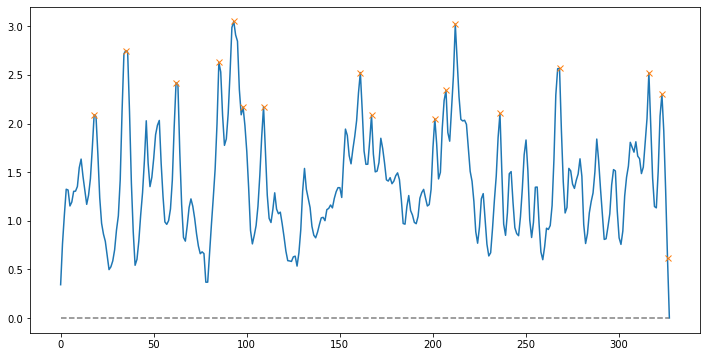

Peak count: 17
Frame tokens: 소녀의 맞이했어요. 소녀는 왕궁에서 언니들을 무도회에 무도회에 드레스로 할머니는 왕자님도 무도회장에 않고,신데렐라하고만 왕궁을 결혼하겠어요. 왕궁으로 결혼하여 살았대요. 

Similarity : 0.4716061490671215
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.524104118347168 Generator / grammar loss:-0.18963176012039185   similarity loss:-0.13596965372562408


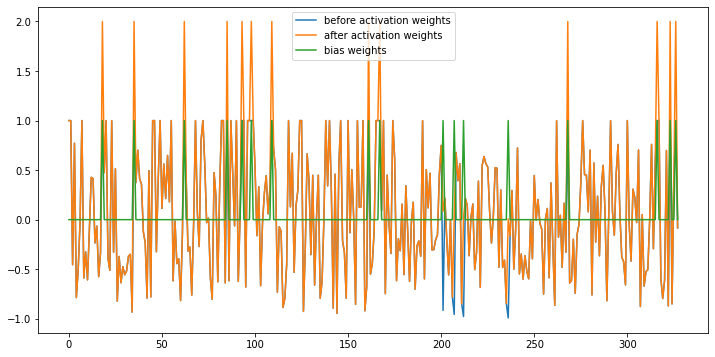

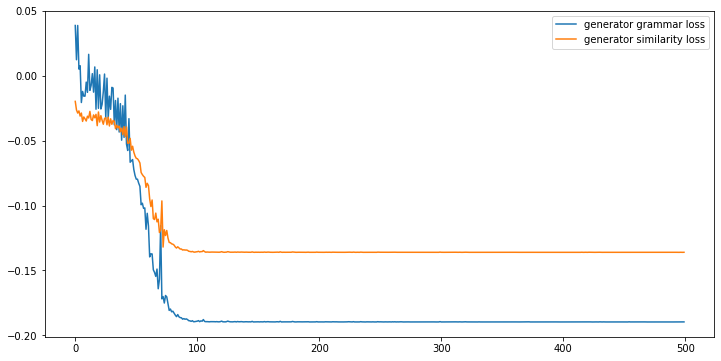

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
 옛날 태어났어요. 소녀의 병이들어 떠나고 맞이했어요. 새어머니와 언니들은 심술쟁이들이었어요. 착한 소녀는 집안일을 해도 했지요. 어느 왕궁에서 열렸어요. 초대장이 언니들을 데리고 떠났어요. 신데렐라도 무도회에 가고 무도회에 웃고 호박 한개와 건드리자, 화려한 도마뱀을 흰말로, 신데렐라의 장식이 드레스로 내밀어 보거라. 할머니는 반짝반짝 주었어요. 돼. 가서 결혼하겠어요. 나라를 그때, 수 왕궁으로 데리고 결혼하여 살았대요.
--------------------------------------------------
     method  comp ratio    intro      body   ending       var     total  \
0  SAM+WGAN    0.165055  0.58092  0.541752  0.46119  0.002484  0.538859   

    grammar  
0  0.982365  
Current result ==================================================
Sample count: 1
     method  comp rate    intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.165055  0.58092  0.541752     0.46119  0.002484     0.538859   

   grammarity  
0    0.982365  
2 / 70
------------------------------------------------------------------
이 이야기에서는 내가 직접 입회한 사건이나 장면만을 이야기하는 전의 내 방법을 바꿔

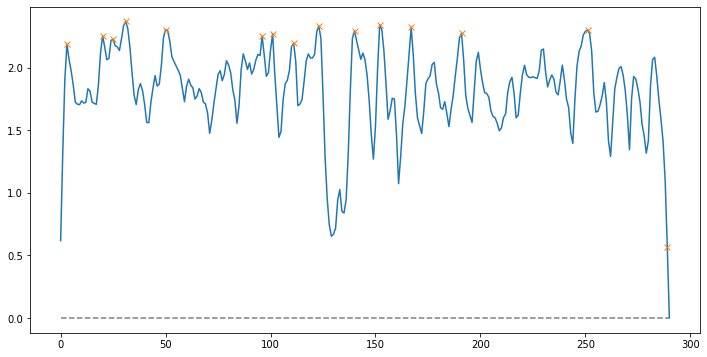

Peak count: 15
Frame tokens: 내가 이제부터의 모두 것임을 한 있다. 있다고. 다뤄 말해도 그때는 있었다. 있었다. 것이었다. 포아로는 관찰했다. 

Similarity : 0.3609225291258562
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.429614305496216 Generator / grammar loss:-0.1590903401374817   similarity loss:-0.1154492199420929


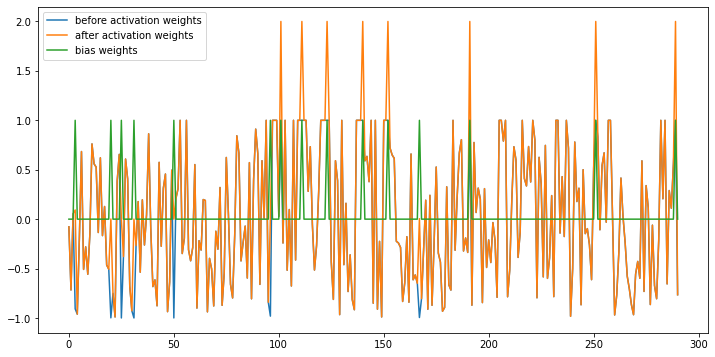

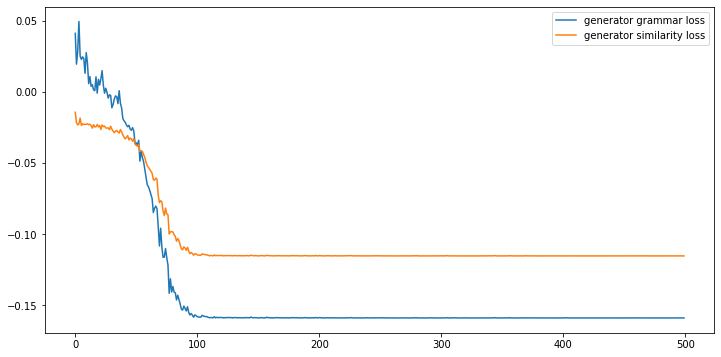

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
그것들은 친구 준 로맨스란 범죄의 부산물일 있다고. 수수께끼의 에르큘 이제까지 그가 다뤄 온 어느 진정한 천재성을 발휘했다고 말해도 좋으리라. 나는 머무를 예정으로 귀국했다. 그때는 사람들과 우리 어려움을 겪고 있었다. 말할 것이었다. 건물을 고른 완전히 그는 기분 모난 것같이 오래된 포아로는 그걸 기억하고 있지. 나는 관찰했다.
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.163862  0.440282  0.555253  0.381184  0.005223  0.462631   

    grammar  
0  0.961727  
Current result ==================================================
Sample count: 2
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.164459  0.510601  0.548503    0.421187  0.003854     0.500745   

   grammarity  
0    0.972046  
3 / 70
------------------------------------------------------------------
그는 굉장히 활기가 넘쳐 전에 만났을 때보다 조금도 더 나이먹은 것같이 보이지 않았다. “자네는 정말 건강해 보이는군, 포아로. 거의 나이를 안 먹었잖나. 전에 만났을 

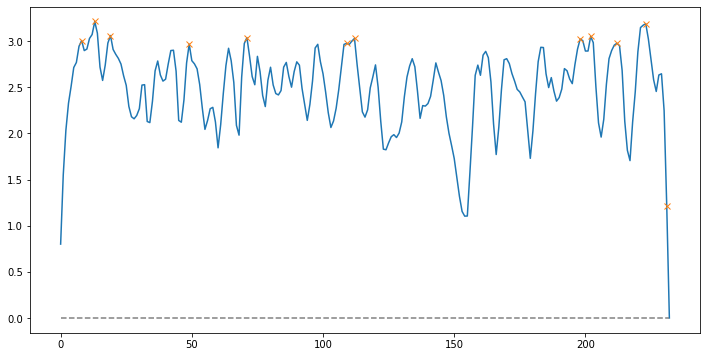

Peak count: 12
Frame tokens: 조금도 않았다. 거의 진짜 ” 자신은 못하지만!” 지금도 움찔했다. 자랑했다. 않아. 수염이라니? 

Similarity : 0.5120790327046825
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.305474042892456 Generator / grammar loss:-0.1532188355922699   similarity loss:-0.12243049591779709


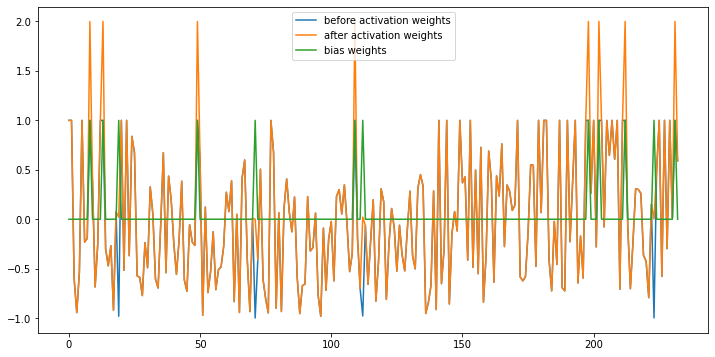

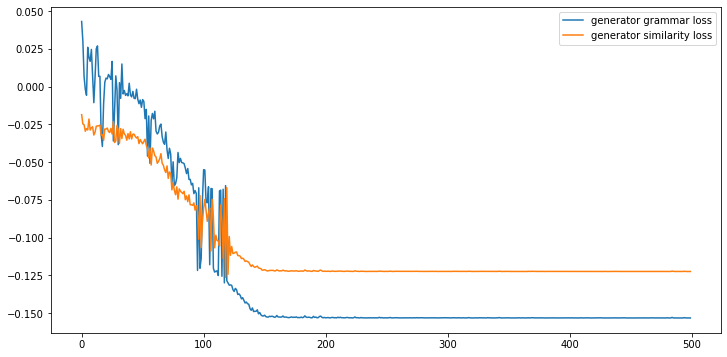

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
 그는 전에 조금도 보이지 않았다. 나이를 먹었잖나. 진짜 자연 자신은 씌어 - 밤색, 검은 모양이군!” 검어 말인가?” “그렇지. 말했다. 돌아왔을 수염이라도 아니면 지금도 수염인가?” 움찔했다. 수염은 그가 신경쓰는 그는 터무니없이 자랑했다. 날은 오지 비네. 수염이라니?
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN     0.16577  0.566754  0.433699  0.729325  0.014614  0.544327   

    grammar  
0  0.884548  
Current result ==================================================
Sample count: 3
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.164896  0.529319  0.510235      0.5239  0.007441     0.515272   

   grammarity  
0     0.94288  
4 / 70
------------------------------------------------------------------
끔찍한 소리를!” 그의 수염이 진짜인 것을 증명하기 위해 힘주어 잡아당겨 보였다. “과연 아직 숱이 꽤 많군. ” “그렇지? 온 런던을 다 찾아봐도 나에게 맞는 가짜 수염은 있을 리 없네. ” 꽤 우쭐대는군 하고 나는 마음속

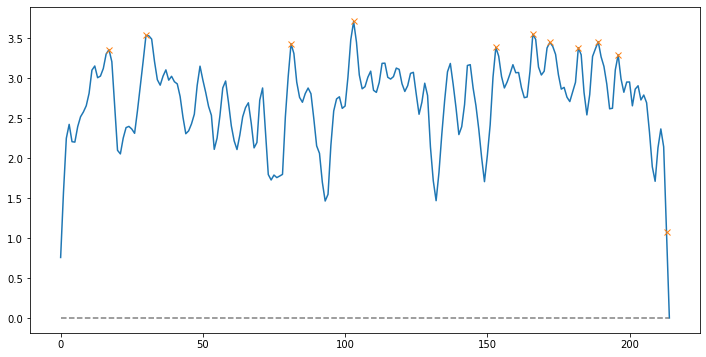

Peak count: 11
Frame tokens: ” ” 셈일세. 말일세. ” 뻔했었어. “당치도 뻔했었지. ” 하지만 “정말인가? 

Similarity : 0.5059245859136656
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:1.9531223773956299 Generator / grammar loss:-0.12523490190505981   similarity loss:-0.1299235075712204


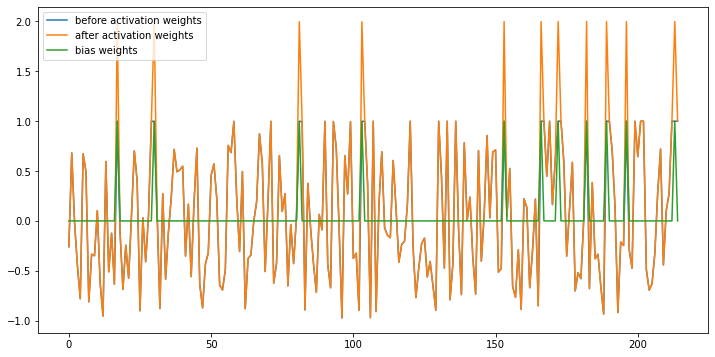

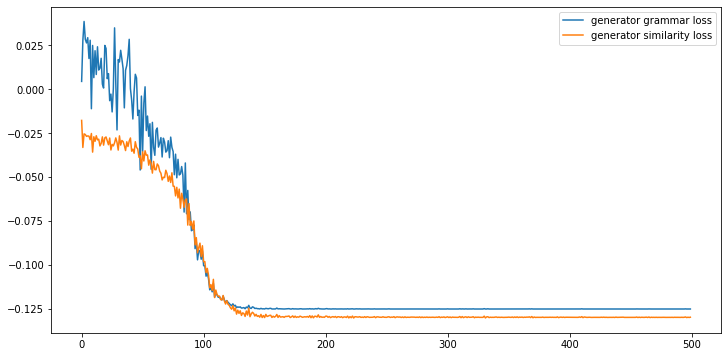

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
” 없네. ” “자네가 그런데 셈일세. 그 자진해서 여는 공연이 말일세. ” “실로 나는 조그만 쓰지 버리니까. ” 뻔했었어. ” 포아로는 “당치도 않네. 뻔했었지. ” “대담하다기보다 하지만 그만두세. 헤이스팅즈, 알겠나? ” “정말인가? 
--------------------------------------------------
     method  comp ratio     intro      body    ending       var    total  \
0  SAM+WGAN    0.158451  0.507513  0.554417  0.721253  0.008413  0.57155   

    grammar  
0  0.896625  
Current result ==================================================
Sample count: 4
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.163284  0.523867  0.521281    0.573238  0.007684     0.529342   

   grammarity  
0    0.931316  
5 / 70
------------------------------------------------------------------
어떤 뜻에서?” 포아로는 내 물음에는 직접 대답하지 않고 이야기를 계속했다. “자네가 온다는 이야기를 들으면 나는 곧 무언가 일어나겠군 하고 생각된다네. 예전처럼 둘이서 수사하지 않겠나. 하지만 만일 그렇게 한다면 평범한 사건은 안돼. 뭔가 이렇게……. ” 그는

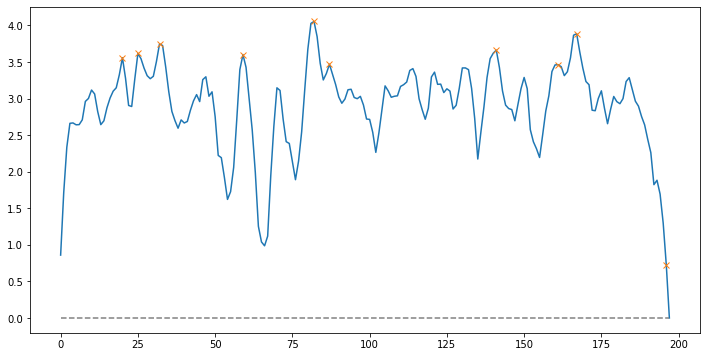

Peak count: 10
Frame tokens: 생각된다네. 하지만 뭔가 말투였다. 정말이야. 운명이라 왜냐하면……. 천천히 ” 갔다. 

Similarity : 0.5046366030420238
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.2328062057495117 Generator / grammar loss:-0.15417803823947906   similarity loss:-0.13079142570495605


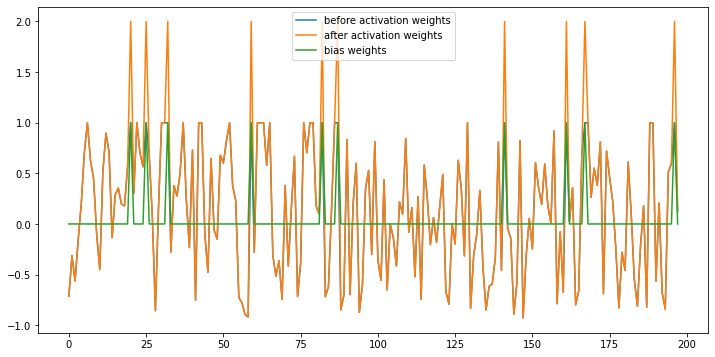

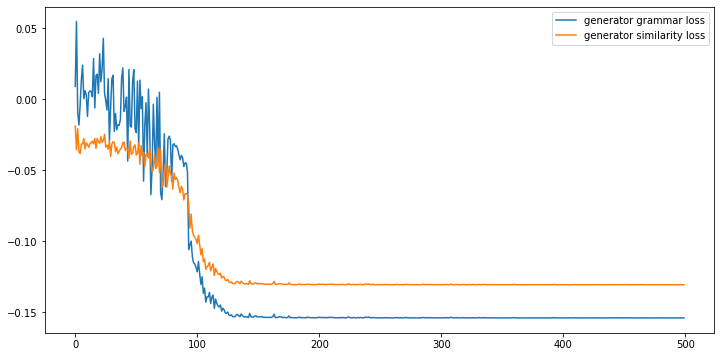

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
직접 생각된다네. 둘이서 하지만 사건은 안돼. 뭔가 손을 쓰게 하는, 번역하기 말투였다. 남이 들으면 마치 저녁 주문할 있는 게 정말이야. 믿겠네. 운명이라 말했다. 왜냐하면……. 천천히 ” 그 고개를 끄덕이고 갔다.
--------------------------------------------------
     method  comp ratio     intro      body    ending      var     total  \
0  SAM+WGAN    0.155727  0.613453  0.559036  0.476714  0.00316  0.569601   

   grammar  
0  0.85689  
Current result ==================================================
Sample count: 5
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.161773  0.541784  0.528832    0.553933  0.006779     0.537394   

   grammarity  
0    0.916431  
6 / 70
------------------------------------------------------------------
책상 속의 것은 말할 나위도 없이 잘 분류되고 정리되어 손을 넣기만 하면 kq로 필요한 서류를 꺼낼 수 있었다. 그는 한 통의 뜯어진 편지를 손에 들고 내 쪽으로 천천히 되돌아왔다. 그리고 그것에 눈길을 한 번 주더니 나에게 내밀며 말했다. “자네는 이걸 어떻게 생각하나?” 나는 어떤 흥미

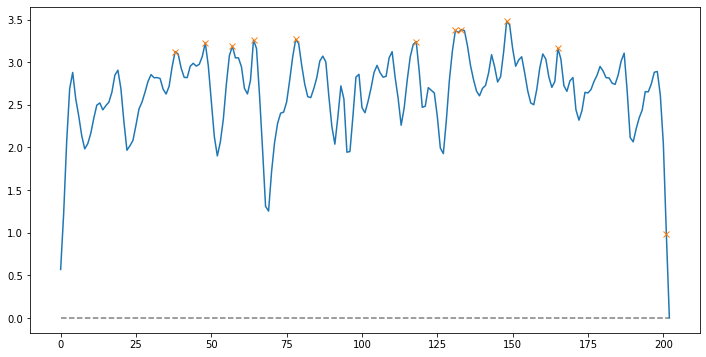

Peak count: 11
Frame tokens: 말했다. 바았다. 에르큘 아닐까. 자신이라고? 말했다. “아마도 짓이겠지. 나는 하지. “뭐라고? 

Similarity : 0.45827783008087164
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.3424477577209473 Generator / grammar loss:-0.1880035698413849   similarity loss:-0.15341812372207642


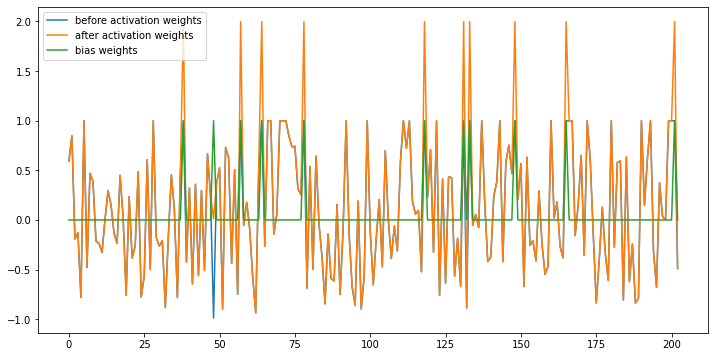

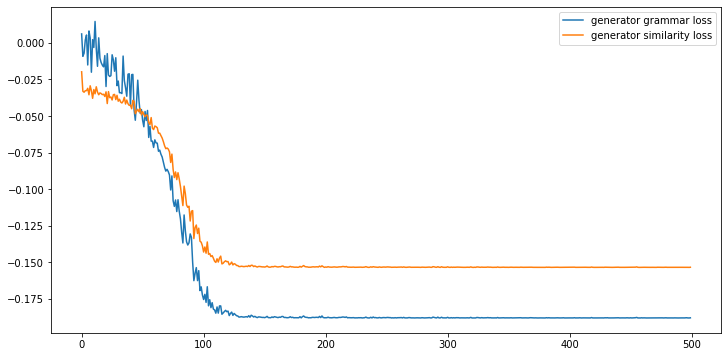

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
나위도 천천히 말했다. 에르큘 아닐까. 우리 멍청이 감당하지 못하는 어려운 자신이라고? 너무 이만. 소인에 돌리고 말했다. 그래, “아마도 짓이겠지. 미치광이로 여겨지네. 나는 포아로. 하지. 미치광이는 아주 물론 내 숫자에 많은 말이네. ” “뭐라고?
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.173645  0.476693  0.608312  0.654059  0.005653  0.597879   

    grammar  
0  0.944407  
Current result ==================================================
Sample count: 6
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.163752  0.530936  0.542078    0.570621  0.006591     0.547474   

   grammarity  
0    0.921094  
7 / 70
------------------------------------------------------------------
아홉이란 말인가? 그건 대체 무슨 뜻이지?” “아니, 그냥 말장난일세. 취한 녀석이라는 뜻이지. 아니, 그보다도 지나치게 마셔서 고주망태가 된 녀석이라는 뜻일세. ” “고맙네, 헤이스팅즈. 그 <취한다>는 말이라면 나도 알고 있네. 자네 말대로 그

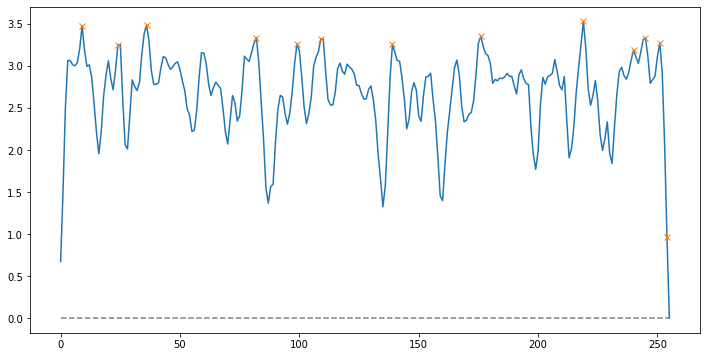

Peak count: 13
Frame tokens: 말장난일세. 그 모르지만. 말일세. ” 대답했다. “자네가 ” 말일세. 되겠나. 없었다. 이상스럽게 항의했다. 

Similarity : 0.5328233908969753
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.062431812286377 Generator / grammar loss:-0.12653107941150665   similarity loss:-0.12028586864471436


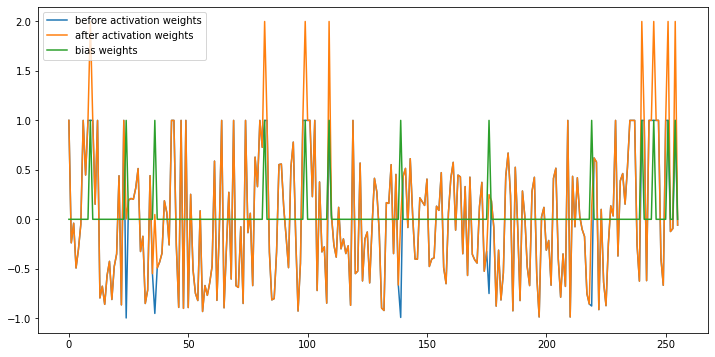

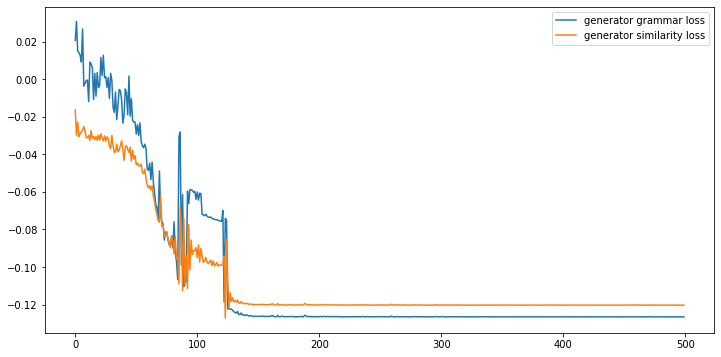

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
 뜻이지?” 그냥 말장난일세. 취한 뜻이지. 헤이스팅즈. 물어 보았다. 무엇이 생각하나?” 했나?” 재프 자네와 녀석의 말일세. 그것이 거였어. ” “하지만 자네는 편지를 대답했다. 헤이스팅즈. 또 앤도버에서 ” “아, 그렇다면 되겠나. ” 나는 어이가 없었다. 그 자리에서 너무나 이상스럽게 항의했다.
--------------------------------------------------
     method  comp ratio     intro    body    ending       var     total  \
0  SAM+WGAN    0.160494  0.680904  0.5524  0.549672  0.003749  0.568734   

    grammar  
0  0.855713  
Current result ==================================================
Sample count: 7
     method  comp rate    intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.163286  0.55236  0.543553    0.567628  0.006185     0.550512   

   grammarity  
0    0.911754  
8 / 70
------------------------------------------------------------------
“강도는 스릴이 있을지 모르지만 기분전환이라고 할 수는 없어!” 포아로는 힘주어 고개를 저었다. “자네는 잘못 알고 있네. 자네는 내 말뜻을 모르고 있어. 내 마음을 차지하고 있는 더 큰 다른 염려에 비하면,

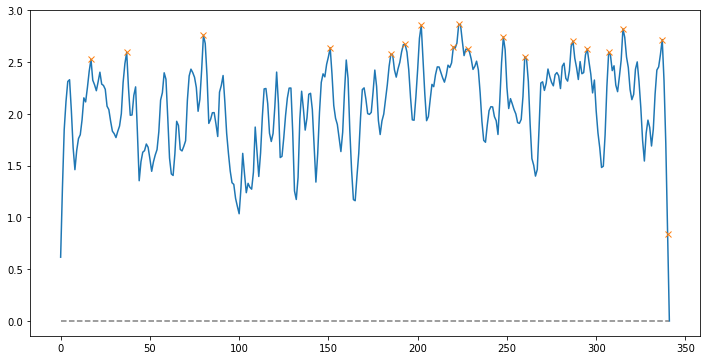

Peak count: 18
Frame tokens: 자네는 걸세. 알았으리라. 사실이지만, 때문에 큰소리로 드디어 하군요. 벗겨졌는가요? 나도 것이다. 그래서 늘그막에 유명한 정말이지 유명해지셨답니다. 이건 정말. 

Similarity : 0.4528614962400055
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.1140575408935547 Generator / grammar loss:-0.12067955732345581   similarity loss:-0.1092614158987999


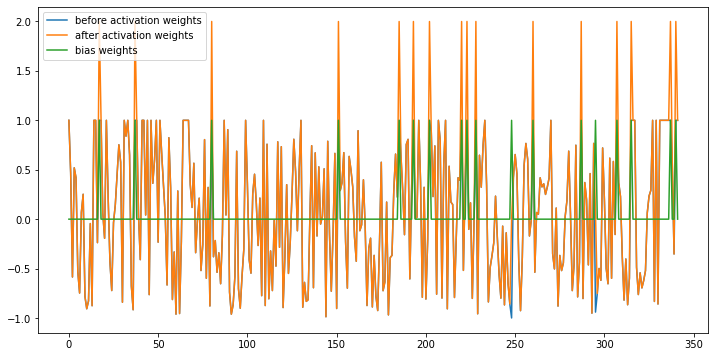

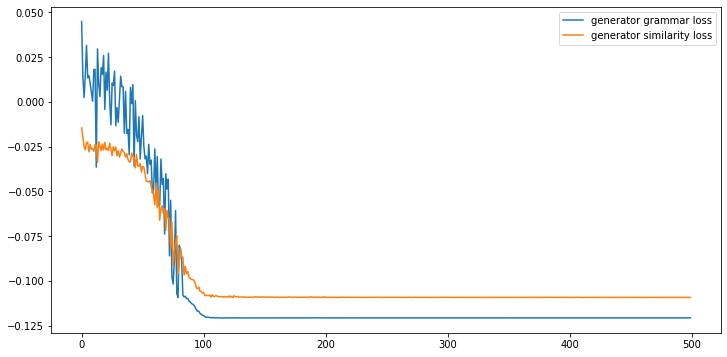

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
 잘못 알고 자네는 내 있어. 강도는 마음 걸세. ” “살인이지. ‘ 삽 > 캐스트 의자에서 완전히 뻣뻣해져 버렸다. 등을 알았으리라. 아주 싸구려 돌아왔다. 그것은 사실이지만, 때문에 큰소리로 내가 드디어 포아로 당신을 하군요. 벗겨졌는가요? 나도 놀랐다. 그래서 재프 늘그막에 정말이지 유명해지셨답니다. ” 포아로가 프리마돈나 “마지막에는 죽음을 탐정한다 해도 우스운 일이 아닐겁니다. 이건 정말. 
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.164354  0.479311  0.551011  0.541771  0.001014  0.525347   

    grammar  
0  0.951901  
Current result ==================================================
Sample count: 8
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN    0.16342  0.543229  0.544485    0.564396  0.005539     0.547366   

   grammarity  
0    0.916772  
9 / 70
------------------------------------------------------------------
책에 써둬야겠어. ” 재프 경감은 커다랗게 웃었다. 포아로는 내게 눈짓을 해보였다. “그것을 해야

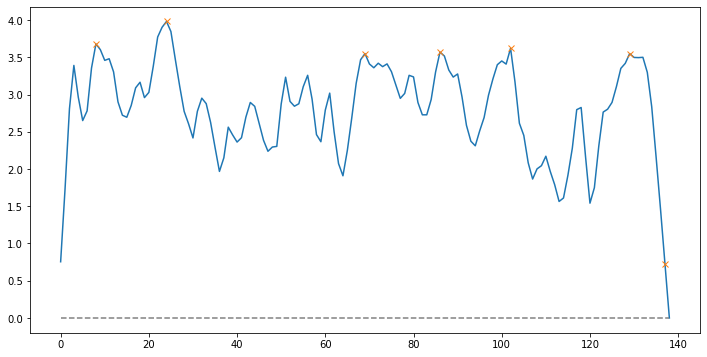

Peak count: 7
Frame tokens: 포아로는 농담입니다. “저번에 “21일입니다. 장난이었지요. 인정했다. 말했다. 

Similarity : 0.5481988403752261
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.0577425956726074 Generator / grammar loss:-0.13753314316272736   similarity loss:-0.13175727427005768


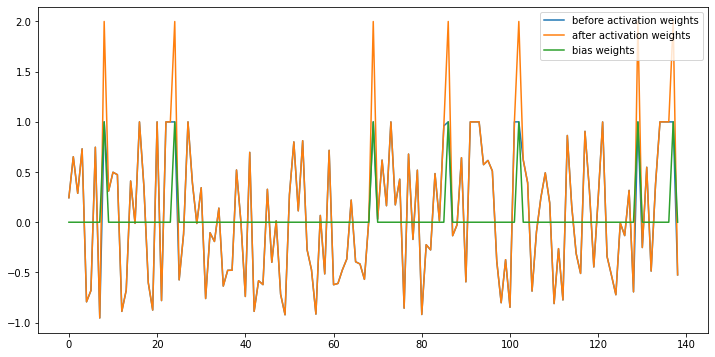

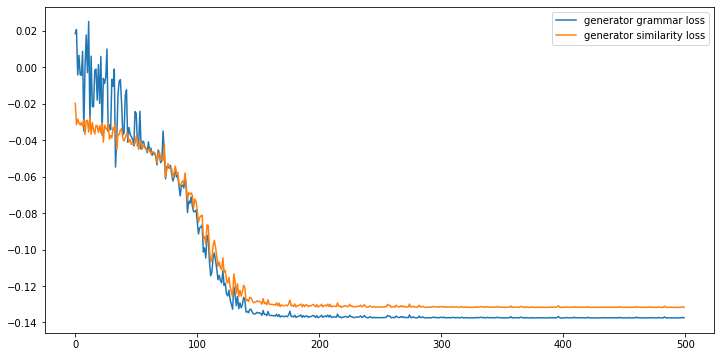

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
포아로는 우선 경감은 “하하하! 농담입니다, 농담입니다. 그 “저번에 나는 “21일입니다. 어제가 21일이었기 때문에, 역시 장난이었지요. 친구분(포아로)이 인정했다. 재프 경감이 동정하듯 말했다.
--------------------------------------------------
     method  comp ratio    intro     body    ending       var    total  \
0  SAM+WGAN    0.186757  0.50838  0.52075  0.551751  0.000333  0.52519   

    grammar  
0  0.919174  
Current result ==================================================
Sample count: 9
     method  comp rate     intro      body  conclusion  isthmus  simlirality  \
0  SAM+WGAN   0.166013  0.539357  0.541848    0.562991  0.00496     0.544902   

   grammarity  
0    0.917039  
10 / 70
------------------------------------------------------------------
“많이 염려하고 계신 것 같았습니다만? 가엾게도, 우리는 그런 것을 날마다 몇십 통씩 받는답니다. 달리 아무 하릴없는 머리가 좀 이상한 사람들이 그런 것을 쓰지요. 그리 악의가 있는 건 아닙니다. 뭐, 일종의 흥분에서지요. ” 포아로가 말했다. “그걸 그토록 진지하게 생각했던 건 정말 어리석은 짓이었습니다. 내가 

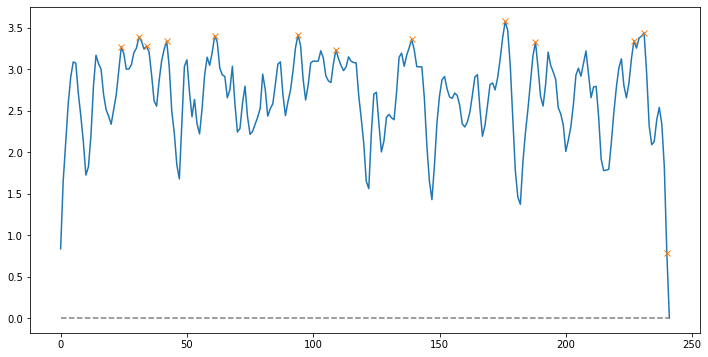

Peak count: 13
Frame tokens: 그리 흥분에서지요. 말했다. 짓이었습니다. 속담입니다. 말했다. ” 알겠지만. 그런 말이야. ” 말일세. “그렇네. 

Similarity : 0.47729378870239647
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.0643370151519775 Generator / grammar loss:-0.14702649414539337   similarity loss:-0.1405905783176422


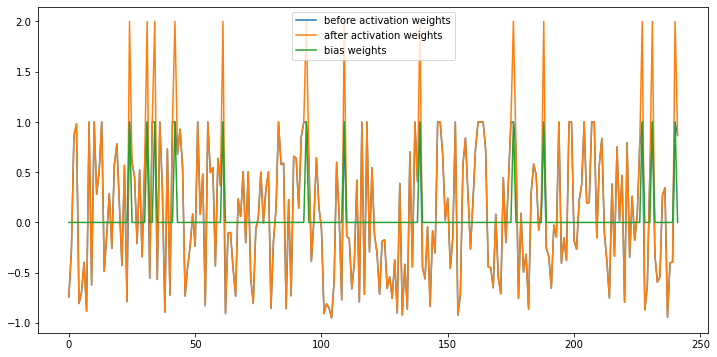

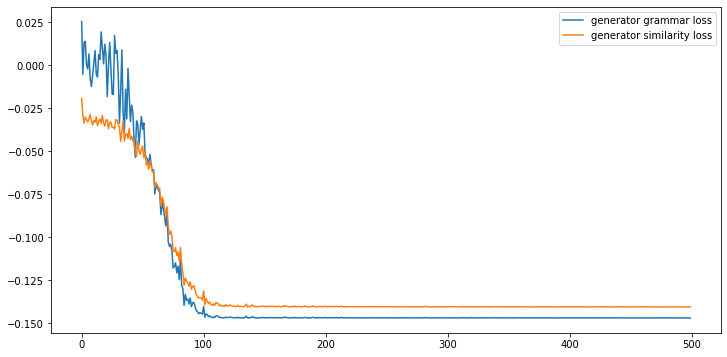

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
그런 날마다 받는답니다. 그리 흥분에서지요. 포아로가 말했다. 그토록 어리석은 짓이었습니다. 재프 벌을 속담입니다. 뜻없이 포아로가 말했다. ” 아주 장치가 아닐세, 알겠지만. 자네 이발사의 대체 아무렇지도 않아, 아무렇지도. 아닐세! 그런 말이야. “그게 해도 재프 아니야. 기분좋지 않았지. ” 말일세. “그렇네.
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.178788  0.638899  0.541274  0.616866  0.001748  0.590665   

    grammar  
0  0.939939  
Current result ==================================================
Sample count: 10
     method  comp rate     intro     body  conclusion   isthmus  simlirality  \
0  SAM+WGAN    0.16729  0.549311  0.54179    0.568379  0.004639     0.549478   

   grammarity  
0    0.919329  
11 / 70
------------------------------------------------------------------
” 나는 얼마쯤 기분을 돌리며 다시 말했다―머리칼이 적어졌다는 말에 내가 아주 민감해 있다는 것을 인정하지 않으면 안 되겠다. “익명 편지가 아무 일 없었다니 유감이군. ‘ “그것은 

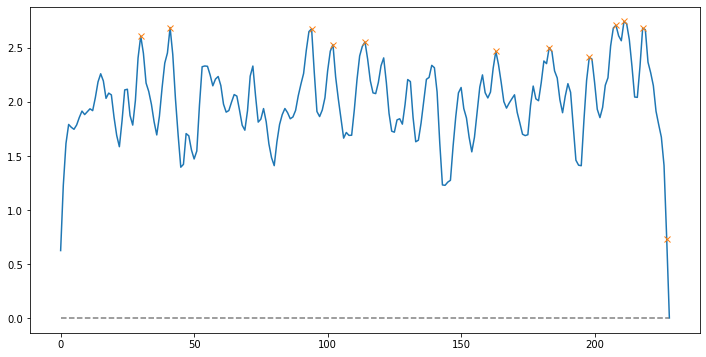

Peak count: 12
Frame tokens: 생각이었네. 장난이었어. 말했다. 위조지폐? 좋겠군. 흉기는 독약. 할까. 빨강머리겠지. 못한 잘못된 생기고. 

Similarity : 0.4675407431984624
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.30543851852417 Generator / grammar loss:-0.148042693734169   similarity loss:-0.1172579973936081


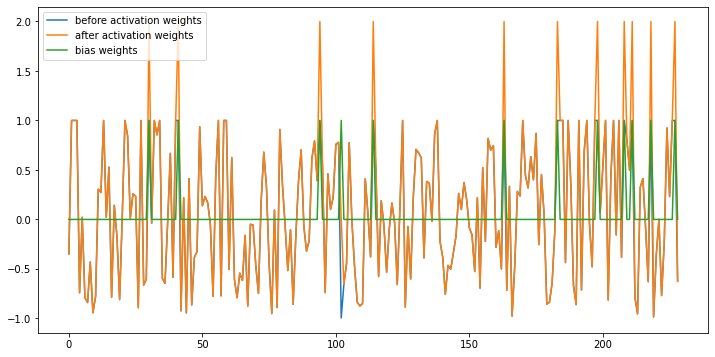

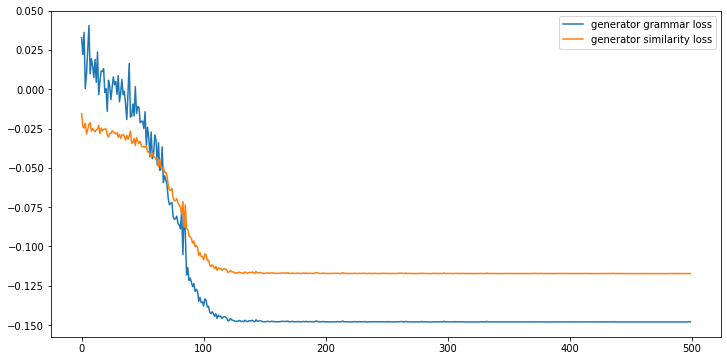

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
” 나는 얼마쯤 있다는 아무 완전히 생각이었네. 편지에 피비린내나는 단순한 장난이었어. ” 웃으며 말했다. 말했다. 좋겠군. 전 남자가 흉기는 둔기 독약. 하지만 이것은 너무 그렇다면 메아리치는 것으로 할까. 여자 ” 중얼거렸다. 빨강머리겠지. 못한 잘못된 오해가 생기고.
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.165397  0.606645  0.351533  0.578226  0.013031  0.482073   

    grammar  
0  0.887492  
Current result ==================================================
Sample count: 11
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.167118  0.554523  0.524494    0.569274  0.005402     0.543351   

   grammarity  
0    0.916435  
12 / 70
------------------------------------------------------------------
물론 그 밖에도 몇 사람에게 혐의가 돌아가지 않으면 안 되네. 이를테면 피해자의 친구거나 경쟁 상대인 피부빛이 검고 위험한 타입의 중년 여자, 얌전한 비서. 이들이 유력한 혐의자인데, 거기에 행동거지가 무뚝뚝하고 성실한 사나

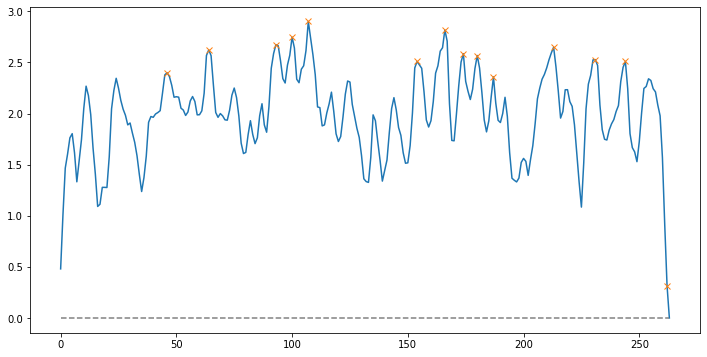

Peak count: 14
Frame tokens: 이쯤이면 지금까지 “아주 범죄. 내밀스러운. 되었을 사건이네. 다들<테이블위의카드>네요. 없는걸. “없지. 자네는 제1장에서 따분하지. 달라졌다. 

Similarity : 0.4973349221693468
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.5036261081695557 Generator / grammar loss:-0.19331857562065125   similarity loss:-0.14184905588626862


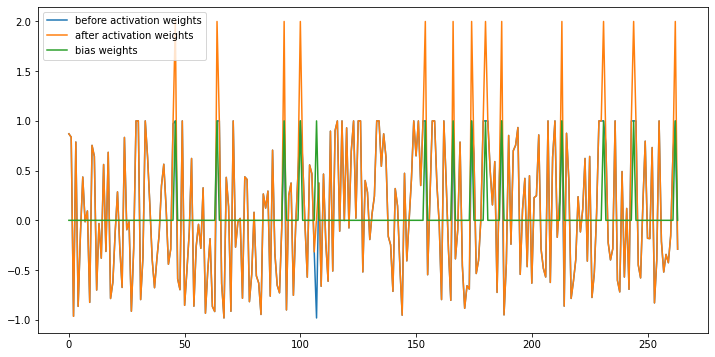

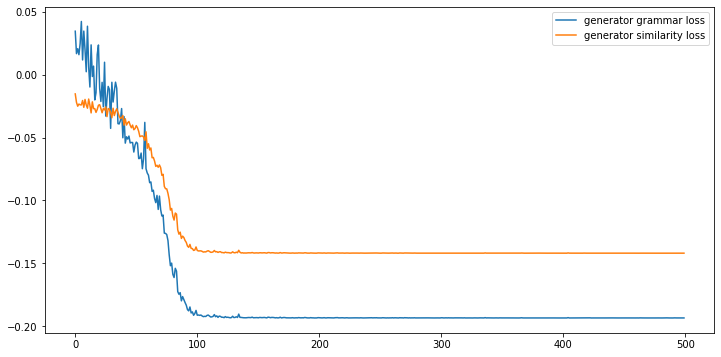

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
무뚝뚝하고 성실한 하인이라든지 이쯤이면 “그것이 지금까지 씌어진 멋있는 “아주 범죄. 중얼거리듯 “네 있네. 한 사람이 의자에 앉아 사람 누군가가 비게 되었을 것인데, 모두들 모르고 사건이네. 다들<테이블위의카드>네요. 조금도 없는걸. ” “없지. 헤이스팅즈, 멜러 자네는 좋아 보이던걸. 제1장에서 바로 좀 따분하지. ‘ ‘ 달라졌다.
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN     0.17636  0.535107  0.494908  0.556824  0.000658  0.530833   

    grammar  
0  0.956775  
Current result ==================================================
Sample count: 12
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.167888  0.552905  0.522029    0.568236  0.005007     0.542308   

   grammarity  
0    0.919796  
13 / 70
------------------------------------------------------------------
그의 대답은 짧게 토막토막 끊어졌다, “그랬군요……물론, 그렇지요……아, 가겠습니다……당연합니다……그야 당신 말대로겠지요. 그렇지요, 갖고 가겠습니다. 그럼, 

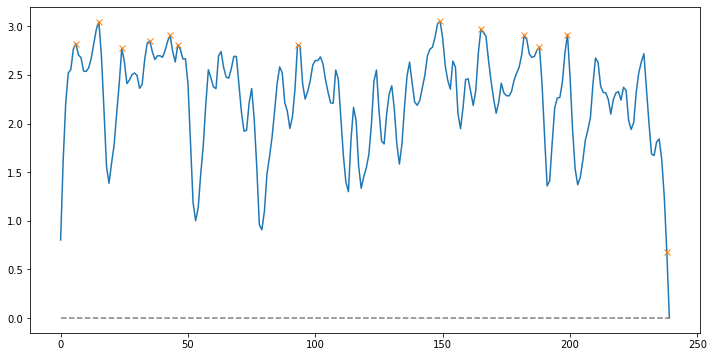

Peak count: 13
Frame tokens: “그랬군요……물론, 곧. 돌아왔다. 앤도버에서 “앤도버?” 말했다. 이었다. 되찾았다. 나는 되살아났다. 시작이다. 받았다. 않았다. 

Similarity : 0.4597893548859251
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.2628884315490723 Generator / grammar loss:-0.151841938495636   similarity loss:-0.1254000961780548


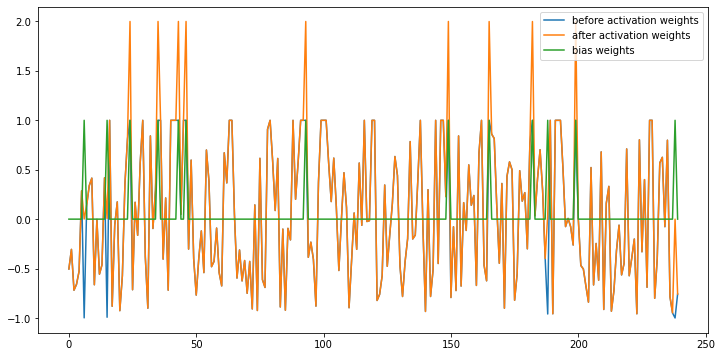

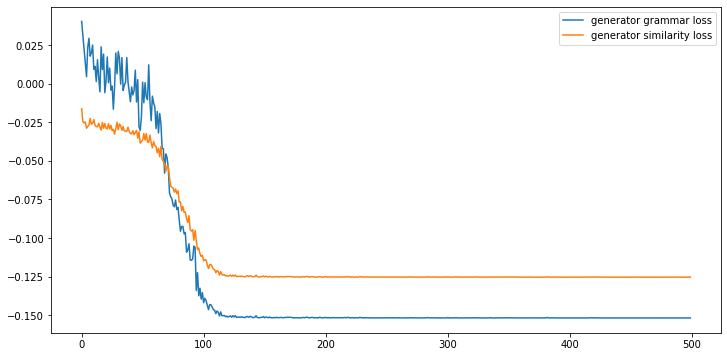

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
” 돌아왔다. 헤이스팅즈. 앤도버에서 연락이 나는 흥분하여 소리쳤다. “앤도버?” 천천히 말했다. 앤도버라는 이름으로 가게 여전히 목소리로 말을 이었다. 있다고 생각하는 모양이야. 남편은 녀석으로 종종 곧 두었네. 나는 얼마쯤 되찾았다. 많은 나는 되살아났다. ” 철도 안내서 > 받았다. 의해 발견되었다.
--------------------------------------------------
     method  comp ratio    intro      body    ending       var     total  \
0  SAM+WGAN    0.168972  0.61661  0.532137  0.473784  0.003438  0.527253   

    grammar  
0  0.877319  
Current result ==================================================
Sample count: 13
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.167972  0.557806  0.522806    0.560971  0.004886     0.541149   

   grammarity  
0    0.916529  
14 / 70
------------------------------------------------------------------
안으로 들어가자 처음에는 아무도 없는 듯했으나, 계산대 쪽으로 회중전등을 돌리니 노파의 웅크린 시체가 눈에 들어왔다. 경찰의가 현장에 와 닿아 노파가 뒷머리를 강하게 얻어맞았음을 알아냈는데, 아

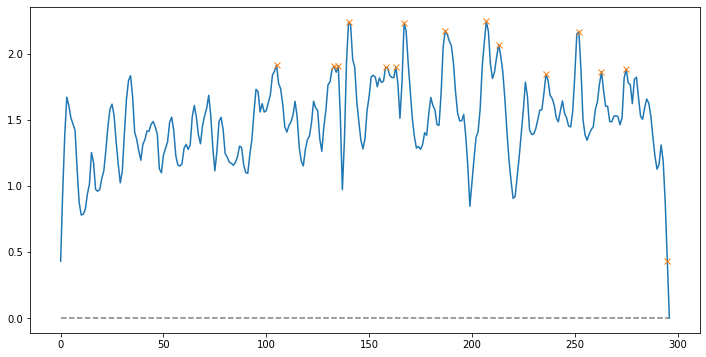

Peak count: 15
Frame tokens: 체포하는 해 헤어졌지요. 급사일을 되었지요. 로즈라는 가정부였습니다. 했답니다. 못했지요. 부인은 정도였지요. 했지요. “없습니다. ” 했답니다. 

Similarity : 0.4129382640260838
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.607710599899292 Generator / grammar loss:-0.17262433469295502   similarity loss:-0.1098720133304596


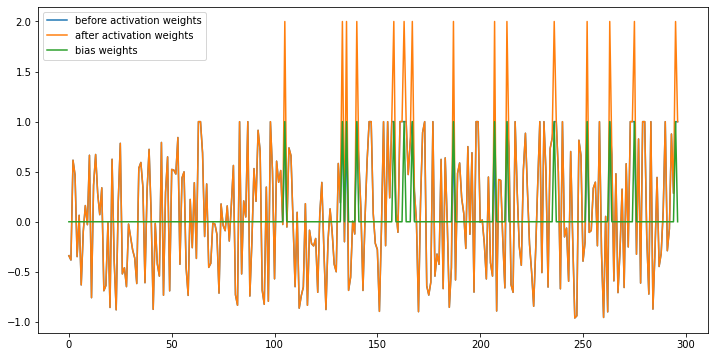

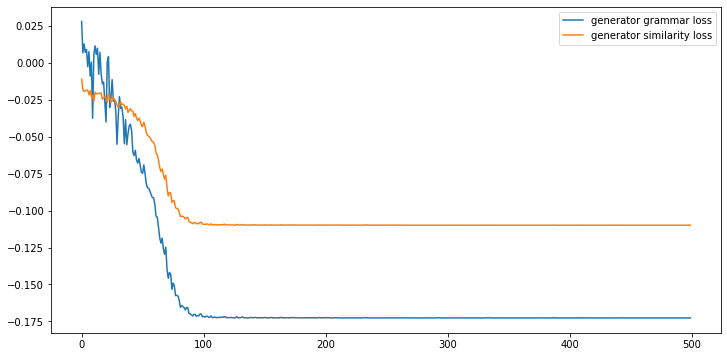

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
5분 좀 5분 있지요. 이제부터입니다. 체포하는 해 헤어졌지요. 급사일을 마셔서 차츰 그래서 부인이 나가게 되었지요. 일은 미스 로즈라는 노부인의 가정부였습니다. 돈을 몽땅 했답니다. 앤도버에서 3마일 못했지요. 부인은 그래서 얼마 되는 정도였지요. 애셔가 그녀에게 했지요. ” “없습니다. 똑똑한 아가씨지요. ” 아내를 자주 “그렇습니다. 머리를 했답니다. 
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.165296  0.486227  0.551757  0.574008  0.001388  0.540665   

   grammar  
0  0.92984  
Current result ==================================================
Sample count: 14
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.167781  0.552693  0.524874    0.561902  0.004636     0.541115   

   grammarity  
0     0.91748  
15 / 70
------------------------------------------------------------------
애셔 부인은 정말 끔찍한 일을 당한 거지요. ” “그녀는 몇 살이었소?” “60살이 다 되었지요. 아마. 훌륭하고 부지런한 사람이었습니다. 

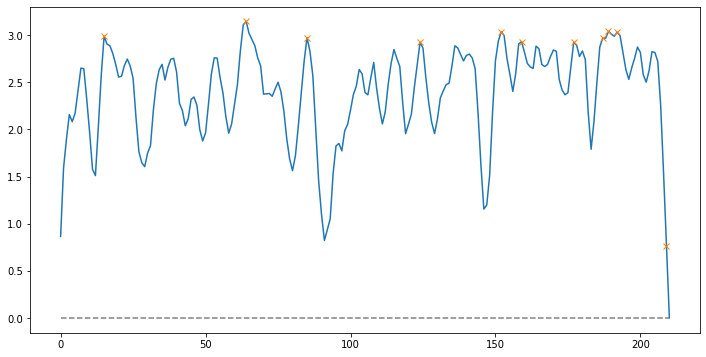

Peak count: 11
Frame tokens: 아마. ” ” 없으니까요. 없지요. 말입니다. 떨릴걸요. 물론 일치겠지만요. ” 있었다. 

Similarity : 0.44490614634061143
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.3466553688049316 Generator / grammar loss:-0.16524186730384827   similarity loss:-0.13022279739379883


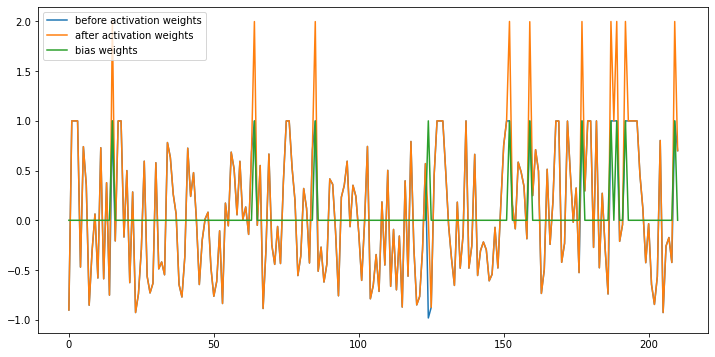

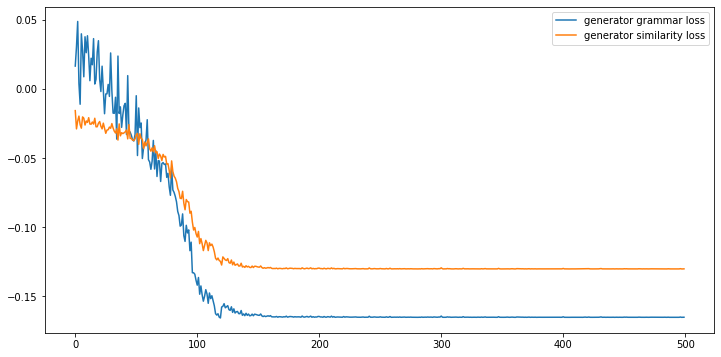

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
애셔 부인은 정말 아마. 부지런한 사람이었습니다. ” 아무것도. 돈도 ” 편지를 건네주자 형사는 “아무래도 턱이 없지요. 말입니다. 다 망가져 글을 떨릴걸요. 잉크도 고급품이고. 편지에는 물론 우연의 일치겠지만요. ” “하지만 이런 일치는 좋지 있었다.
--------------------------------------------------
     method  comp ratio    intro      body    ending       var     total  \
0  SAM+WGAN    0.162442  0.57132  0.492696  0.634063  0.003345  0.529361   

    grammar  
0  0.936804  
Current result ==================================================
Sample count: 15
     method  comp rate     intro      body  conclusion  isthmus  simlirality  \
0  SAM+WGAN   0.167425  0.553935  0.522729    0.566713  0.00455     0.540331   

   grammarity  
0    0.918768  
16 / 70
------------------------------------------------------------------
그의 이마에 주름이 잡혔다. “ABC. 대체 ABC란 어떤 녀석일까요? 메리 드로워―조카딸입니다만―가 좀 도움이 될지도 모르겠군요. 뭐 수고하시는 김에 말입니다. 이 편지만 없다면 나느 프란츠 애셔에게 내기를 걸어도 좋은데요. ” “애셔 부인의 경력은

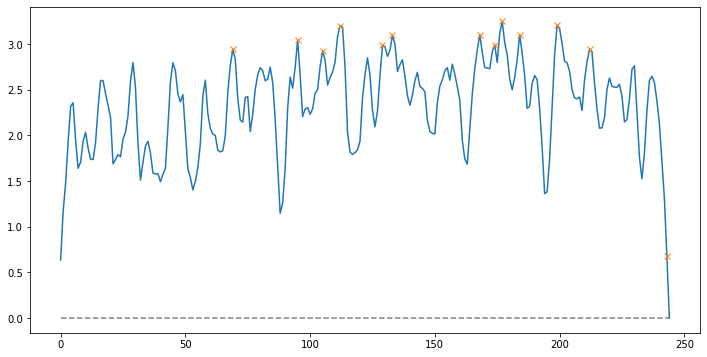

Peak count: 13
Frame tokens: 겁니다. 데려오게. 그는 했다. 날 너무하잖아. ” “그만해 정신차려요. 지금으로서는. ” 않았어! 없어. 

Similarity : 0.5075769934943681
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.386019706726074 Generator / grammar loss:-0.16827088594436646   similarity loss:-0.12917858362197876


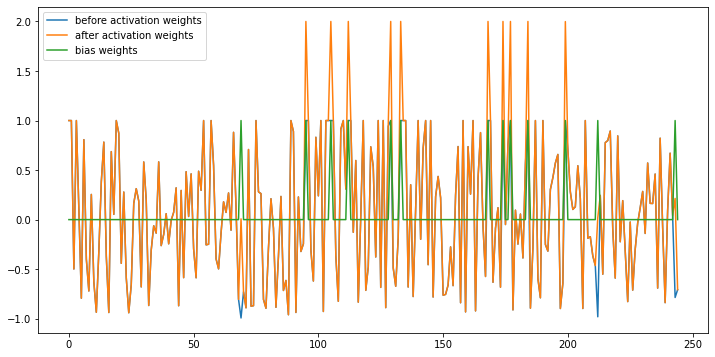

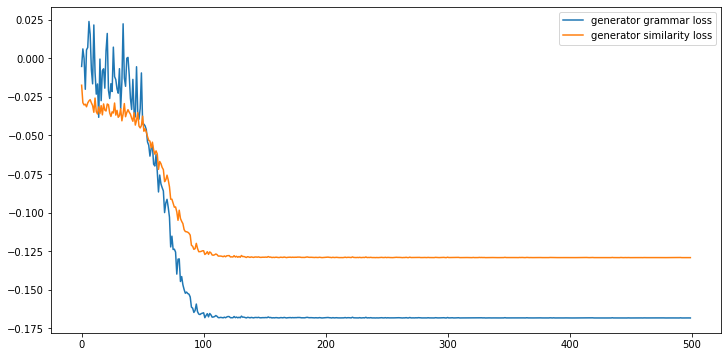

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
 그의 주름이 말입니다. 사람은 있었지요. “무슨 안에 데려오게. ” 싫은, 인간의 표본이었다. 그는 엉엉 서슬이 했다. 그 모두들의 나는 짓도 날 너무하잖아. 네 놈들은 태도가 “아니, 그게 누구나 심하게 ” 애셔는 “그만해 정신차려요. 지금으로서는. 아무 좋소. ” 같았다.
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.154536  0.351481  0.584294  0.500563  0.009271  0.513951   

    grammar  
0  0.906425  
Current result ==================================================
Sample count: 16
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.166619  0.541281  0.526577    0.562578  0.004845     0.538682   

   grammarity  
0    0.917996  
17 / 70
------------------------------------------------------------------
그건 농담이었어. 나와 앨리스만이 알고 있는 농담이야. 앨리스는 그걸 알고 있었어. ” “우스운 농담이로군! 어젯밤 어디 있었는지 말할 수 있소, 애셔?” “말할 수 있고말고, 있고말고. 모두 이야기하지. 난 앨리스한테

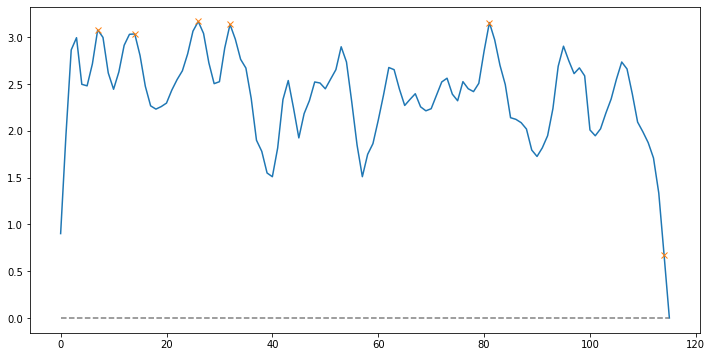

Peak count: 6
Frame tokens: 농담이야. 농담이로군! 모두 친구들하고 “데려가. 놈들입니다. 

Similarity : 0.43774310295095886
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.491168260574341 Generator / grammar loss:-0.16998828947544098   similarity loss:-0.11984668672084808


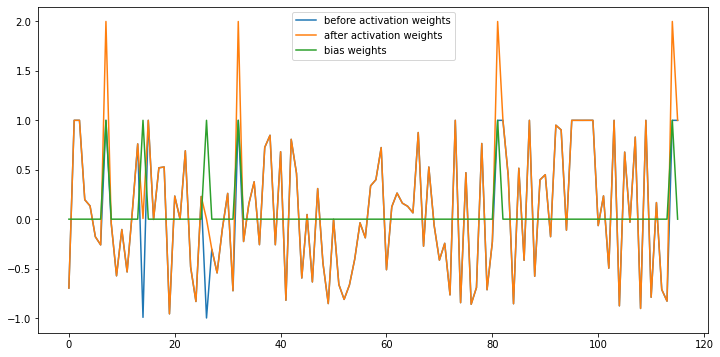

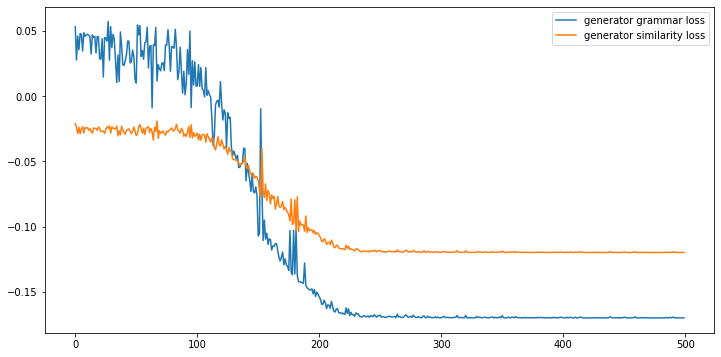

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
그건 농담이었어. 농담이야. 어젯밤 친구들하고 ” “데려가. 용의자를 퍼부어대는 “아무래도 알 수 없군요. 그 늙은이의 말하는 놈들입니다. 
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.163866  0.585894  0.338324  0.460857  0.010215  0.451073   

    grammar  
0  0.973442  
Current result ==================================================
Sample count: 17
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.166457  0.543906  0.515503    0.556595  0.005161     0.533529   

   grammarity  
0    0.921258  
18 / 70
------------------------------------------------------------------
모두 위증쯤은 손쉽게 할 녀석들이지요. 나도 저 늙은이가 그날 밤 어느 시간까지는 그들과 함께 있었다고 생각합니다. 그러니 6시 사이에 가게 언저리에서 저 늙은이를 본 사람이 있는지 없는지에 달렸다고 봐야겠지요. “ 포아로는 신중하게 머리를 저었다. “가게에서 아무것도 없어지지 않은 건 분명하지요?” 형사는 어깨를 으쓱했다. “그야 경우에 따라 다르겠지요

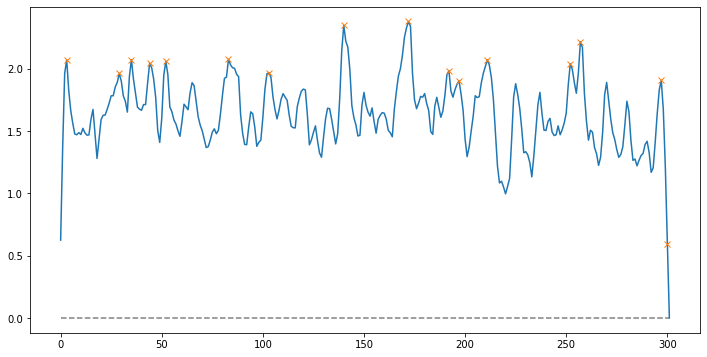

Peak count: 16
Frame tokens: 손쉽게 봐야겠지요. “가게에서 “그야 모릅니다. 있었습니다. 그 “철도 생각된다. 거의 나는 있었다. 시시한 시작했다. 이상한 시작했다. 

Similarity : 0.4049719923751883
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.549880266189575 Generator / grammar loss:-0.19059565663337708   similarity loss:-0.13415563106536865


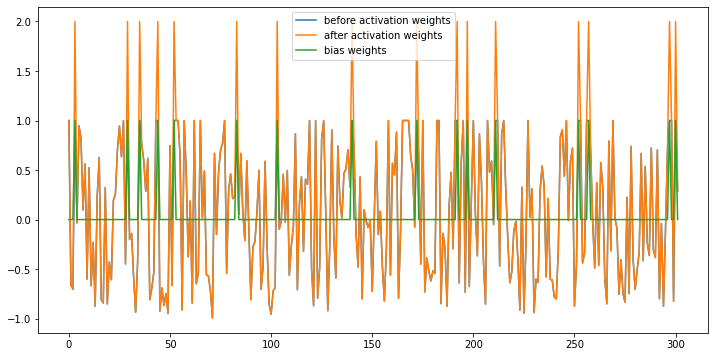

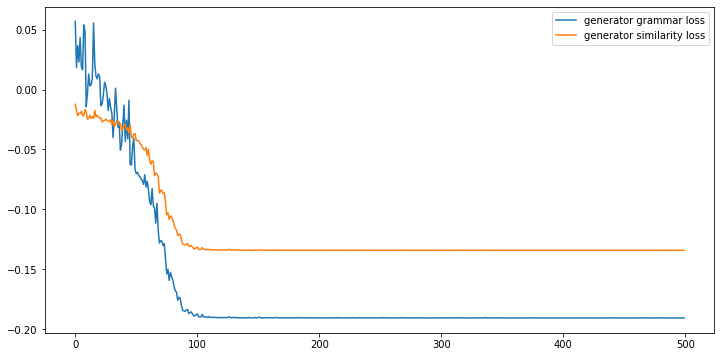

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
 손쉽게 없는지에 봐야겠지요. “가게에서 으쓱했다. “그야 모릅니다. 그러나 아무도 때문에 “게다가 좋을까. 아무것도 있었습니다. 그 시간표를 그것은 가게나 “철도 > 철도 안내서가 나왔을 때 생각된다. 이 노파 살해 범죄여서 거의 못했던 나는 편지가 일치에 있었다. 당연히 그 철도 일치 시시한 범죄가 띠기 시작했다. 누구인가? 이상한 느낌이 시작했다.
--------------------------------------------------
     method  comp ratio     intro     body    ending       var    total  \
0  SAM+WGAN    0.159549  0.467242  0.51761  0.494412  0.000424  0.50087   

    grammar  
0  0.955793  
Current result ==================================================
Sample count: 18
     method  comp rate     intro     body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.166073  0.539646  0.51562     0.55314  0.004898     0.531715   

   grammarity  
0    0.923177  
19 / 70
------------------------------------------------------------------
너무나 평화로워 폭력 같은 것과는 거리가 먼 느낌이었다. 경관이 말했다. “누가 무엇으로 자기를 때렸는지 조금도 모르는 얼굴입니다. 카 의사가 그렇게 말

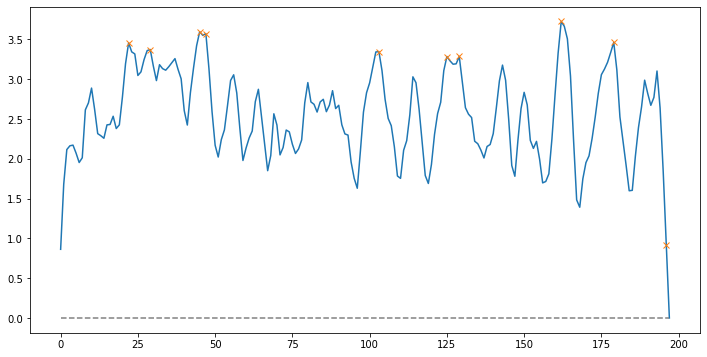

Peak count: 10
Frame tokens: 오히려 사람이었는데. “그럴까. “그렇네. ” 네, 있습니다. “여자도? 가능합니다. 끄덕였다. 

Similarity : 0.5019067524599332
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.193915367126465 Generator / grammar loss:-0.14502878487110138   similarity loss:-0.12557613849639893


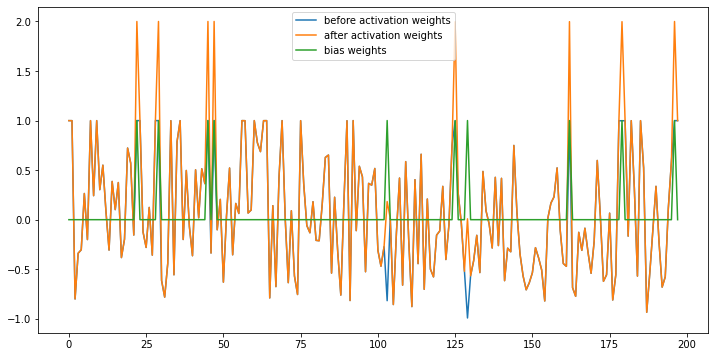

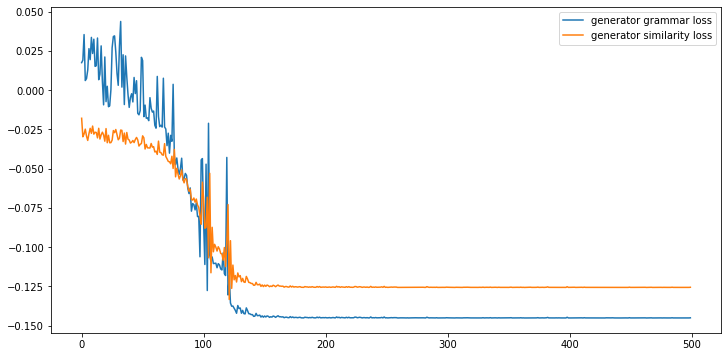

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
 너무나 먼 경관이 오히려 그게 깔끔한 사람이었는데. “옛날엔 같군. “그럴까. “그렇네. 보게. ” 본래대로 쉬었다. 그리고 나왔다. 의사는 알 없지요. 네, “여자도? 완전히 가능합니다. 다만 말해서, 범죄라고 끄덕였다. 
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.155364  0.583464  0.604007  0.596281  0.000072  0.595465   

    grammar  
0  0.945829  
Current result ==================================================
Sample count: 19
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN    0.16551  0.541953  0.520272    0.555411  0.004644      0.53507   

   grammarity  
0    0.924369  
20 / 70
------------------------------------------------------------------
“그렇습니다. 그렇습니다. 확실히 있을 수 없는 일입니다. 그러나 모든 가능성을 염두해 두지 않으면 안 되니까요. 시체는 쓰러져 있었겠지요. 어떤 모습이었습니까?” 의사는 피해자의 위치를 세밀하게 우리에게 설명했다. 그의 말에 의하면, 타격이 주어졌을 때 그녀는 계산대 

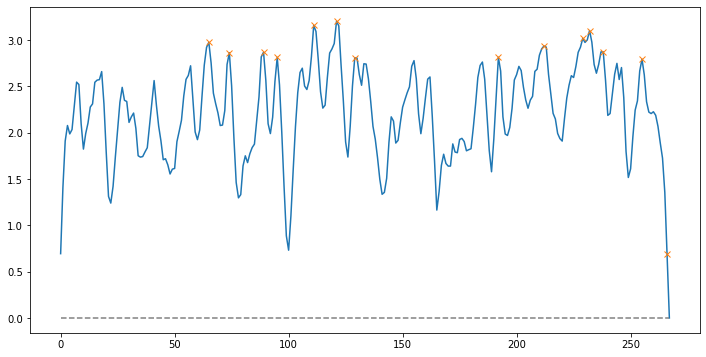

Peak count: 14
Frame tokens: “이로써 헤이스팅즈. 그런데 틀림없이 “기분이 여자일세. “여기서 나왔다. 메리예요. 것입니다. 외출중이세요. ” “아주머니가 솟아났다. 

Similarity : 0.46668731341236325
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.5329911708831787 Generator / grammar loss:-0.17779181897640228   similarity loss:-0.1231742799282074


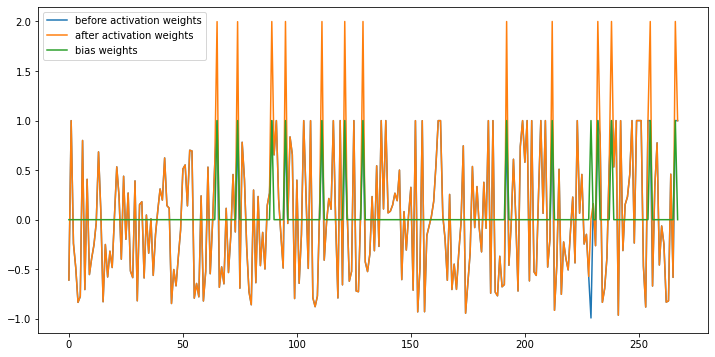

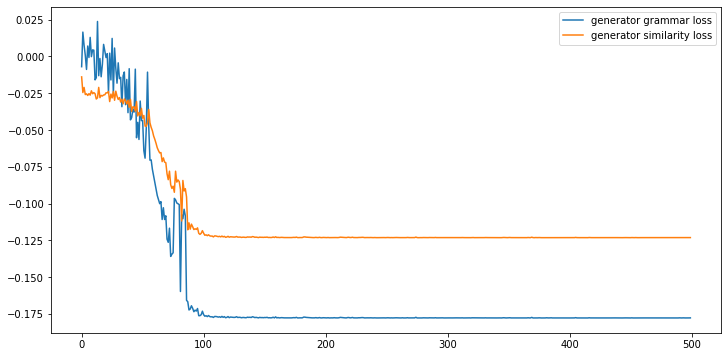

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
“그렇습니다. “이로써 헤이스팅즈. 그런데 가해자에게 틀림없이 했던 ” “기분이 머리를 중얼거렸다. 여자일세. 그는 “여기서 조카딸을 보는게 미루고 있어서. 잠시 뒤 훌륭한 벨을 나왔다. 포아로가 말했다. 당신이 메리 양이군요?” 메리예요. 다름아닌 외출중이세요. ” 조그만 문을 포아로는 의자에 앉아 날카롭게 보았다. “아주머니가 솟아났다. 
--------------------------------------------------
     method  comp ratio     intro      body    ending       var    total  \
0  SAM+WGAN    0.173913  0.513673  0.505671  0.576787  0.001012  0.52545   

    grammar  
0  0.965681  
Current result ==================================================
Sample count: 20
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN    0.16593  0.540539  0.519542     0.55648  0.004462     0.534589   

   grammarity  
0    0.926434  
21 / 70
------------------------------------------------------------------
“오늘 아침 경찰에서 오셨었어요. 아, 무서운 일이에요! 가엾은 아주머니! 그토록 괴로운 나날을 보내고서 또 이런 일을 당하시다니……너무해요. ” “경찰이 

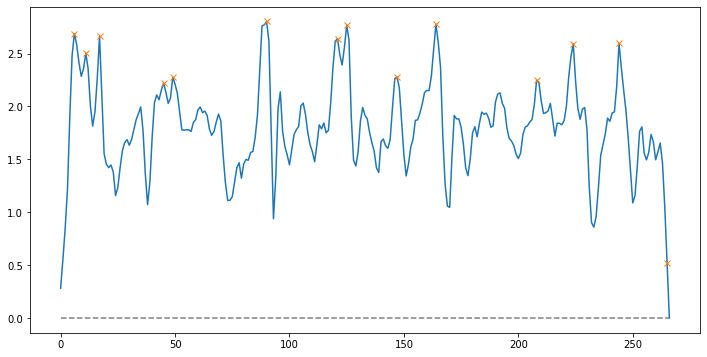

Peak count: 14
Frame tokens: 무서운 괴로운 당하시다니……너무해요. 하녀가 끼치고 했어요. ” 격렬했다. ” 저주스럽게 놀랐어요. 무서워하고 무서워하고 계속했다. 

Similarity : 0.4413670300687168
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.4909355640411377 Generator / grammar loss:-0.18746621906757355   similarity loss:-0.13734938204288483


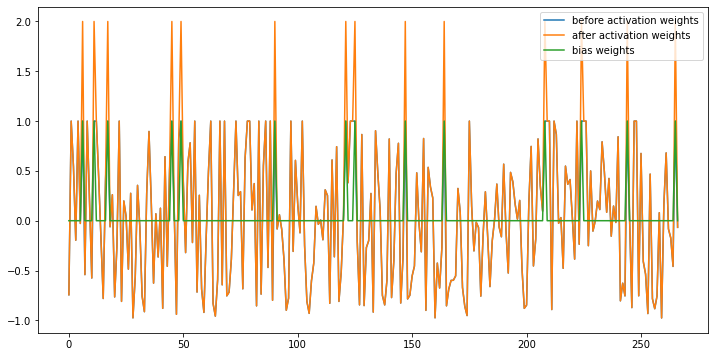

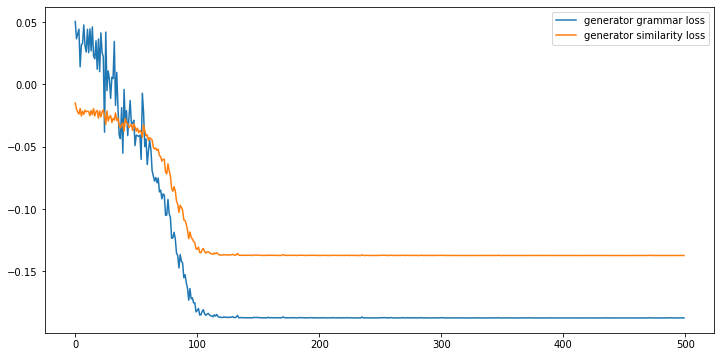

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
“오늘 오셨었어요. 무서운 가엾은 괴로운 나날을 당하시다니……너무해요. 하지 하녀가 끼치고 물었다. “정말 제게 주셨지요. 11살 갔어요. 16살 나와 날이면 아주머니에게 했어요. 먹고 늘 ” 말투는 아주 격렬했다. ” 저주스럽게 즈음에는 놀랐어요. 아무튼 진짜로 소리라고는 않았어요. 무서워하고 계셨던 것 무서워하고 ” “그런데도 계속했다.
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.168877  0.527781  0.505255  0.565113  0.000609  0.526888   

    grammar  
0  0.952073  
Current result ==================================================
Sample count: 21
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN    0.16607  0.539931  0.518862    0.556891  0.004279     0.534222   

   grammarity  
0    0.927655  
22 / 70
------------------------------------------------------------------
“그렇다면 결국 그 남자는 아주머니를 죽이지 않았다는 거로군요?” “죽이지 않았다고요?” 그녀는 눈을 크게 떠보였다. “그렇습니다. 누군가 다른 사람이 아

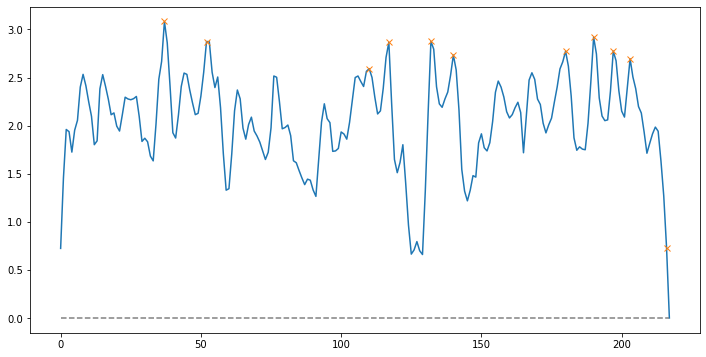

Peak count: 11
Frame tokens: 없어요. 저었다. “아가씨 없어요. 몰라요. 없어요. 중얼거렸다. 없어. “만일 메리 않거든요. 

Similarity : 0.4361013000362318
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.5174145698547363 Generator / grammar loss:-0.1870797872543335   similarity loss:-0.13413530588150024


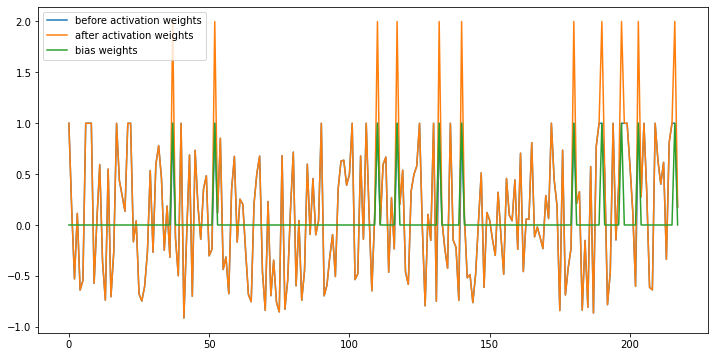

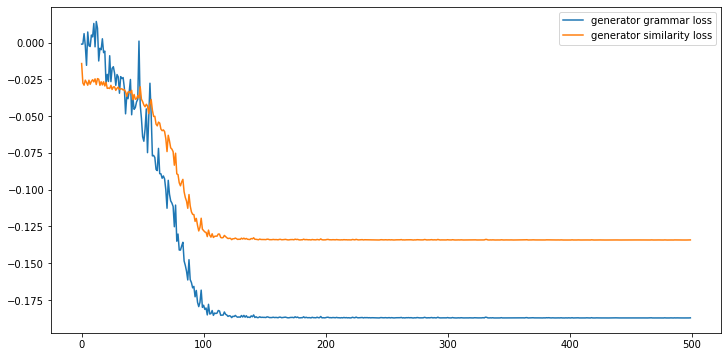

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
 죽이지 않았다는 거로군요?” 다른 죽였다는 말입니다. 없어요. 일이 저었다. 그저 그녀는 묘한 “아가씨 없어요. 전쟁터에서 가버리셔서 몰라요. 어머니는 없어요. 깊게 중얼거렸다. 수 없어. ” “만일 아가씨한테 볼일이 메리 ” 여기를 좋아하지 않거든요.
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.151386  0.557961  0.502592  0.426836  0.002889  0.504662   

    grammar  
0  0.954588  
Current result ==================================================
Sample count: 22
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.165403  0.540751  0.518122    0.550979  0.004216     0.532879   

   grammarity  
0     0.92888  
23 / 70
------------------------------------------------------------------
아주머니 곁에 있는 게 마음 든든히 여겨져 여기 있었던 거예요. 그러나 이젠……. ” 그 눈에 다시 눈물이 솟았다. “이제는 여기 있을 이유가 없어져 런던으로 되돌아가려고 해요. 그곳이 제게는 더 재미있는 걸요. ” “그럼, 그리고 가게 될 

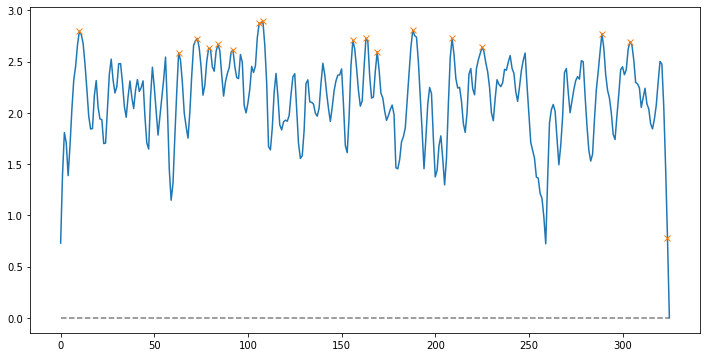

Peak count: 17
Frame tokens: 거예요. ” 말했다. 아가씨. 아마 ” 그러나 감동적이었다. 그는 것이다. 이 있었다. 그런데 있었다. 그러나 포아로는 되풀이했다. 

Similarity : 0.40773925917790566
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.5316009521484375 Generator / grammar loss:-0.17780354619026184   similarity loss:-0.12333562225103378


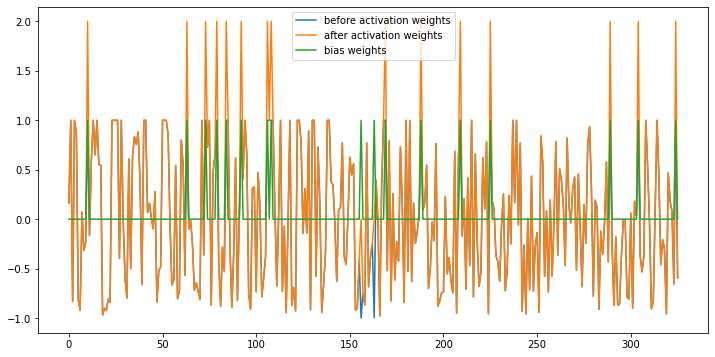

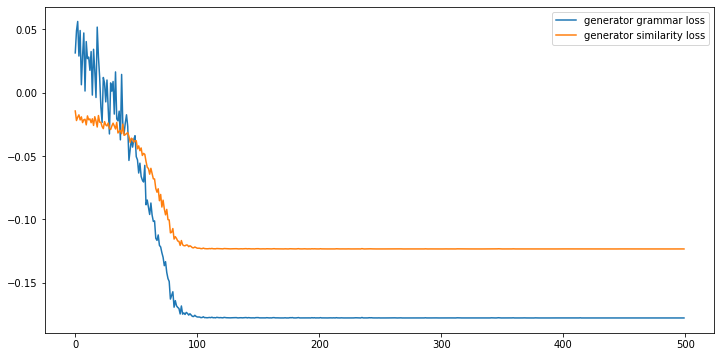

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
아주머니 있는 거예요. ” 눈에 없어져 런던으로 되돌아가려고 해요. 제게는 주십시오. 이것이 곤혹스러운 듯 이마에 ” 이윽고 말했다. 의심스러운 아가씨. 아마 앞으로 ” 저는 그러나 꽤 감동적이었다. 우리는 앤도버로 > 큰길에서 좁은 오른쪽에 있었다. 시계를 보았다. 실패했다. 이 사람들 섞여 있었다. 그런데 집인지 있었다. 여느 무리였다. 그러나 포아로는 섰다. 위에 되풀이했다.
--------------------------------------------------
     method  comp ratio     intro      body    ending      var     total  \
0  SAM+WGAN    0.165891  0.540538  0.544182  0.445908  0.00207  0.524295   

    grammar  
0  0.934422  
Current result ==================================================
Sample count: 23
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.165424  0.540741  0.519255    0.546411  0.004122     0.532505   

   grammarity  
0    0.929121  
24 / 70
------------------------------------------------------------------
“A 애셔. 그렇지, 어쩌면……. ” 그는 말을 끊었다. “가세, 헤이스팅즈. 안으로 들어가 보세. ” 나는 기다리고

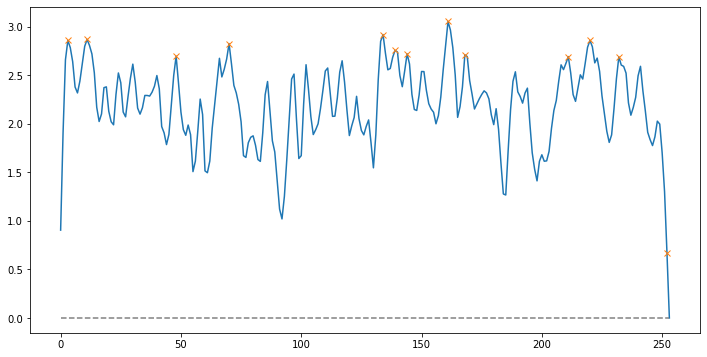

Peak count: 13
Frame tokens: 그렇지, 안으로 들어갔다. 둘러보았다. 선반으로 모르지요. “없었습니다. 둘러보았다. “여기입니다. 보았다. 없었지요. ” 물었다. 

Similarity : 0.47565926817247506
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.56215500831604 Generator / grammar loss:-0.1922900676727295   similarity loss:-0.1345197707414627


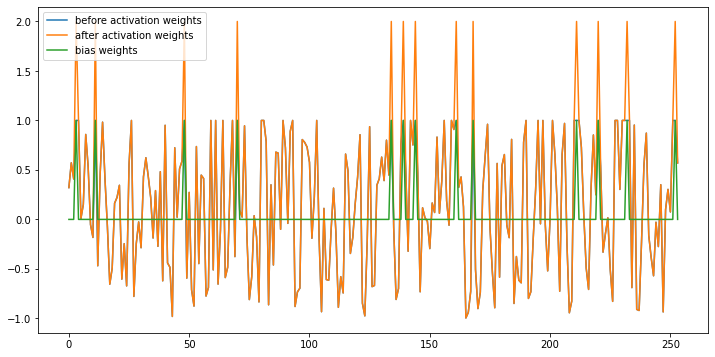

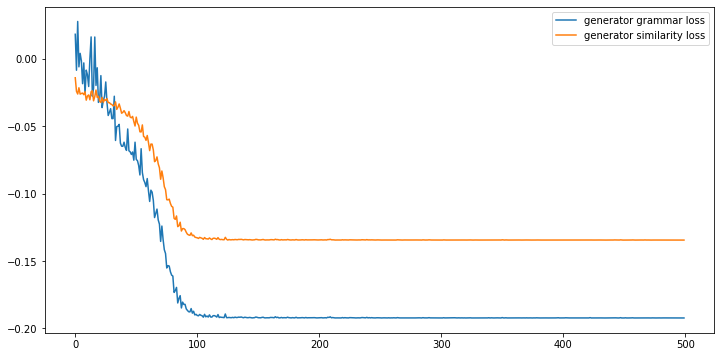

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
그렇지, 어쩌면……. 안으로 형사에게서 들어갔다. 그러나 촉수가 여전히 안을 둘러보았다. 어제 신문에는 선반이 궐련 구멍가게로 선반으로 모르지요. 아무것도 “없었습니다. 눈은 가게를 둘러보았다. “여기입니다. 그는 물론 안내서는 사람이 물어 보았다. “지문은?” 없었지요. 모두 함께 뒤죽박죽되어 있었지요. ” “그 있었느냐고 물었다.
--------------------------------------------------
     method  comp ratio     intro      body   ending       var     total  \
0  SAM+WGAN    0.176249  0.625476  0.528762  0.58827  0.001587  0.566502   

    grammar  
0  0.964529  
Current result ==================================================
Sample count: 24
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.165875  0.544272  0.519651    0.548155  0.004017     0.533922   

   grammarity  
0    0.930596  
25 / 70
------------------------------------------------------------------
“그렇습니다. 안쪽 문을 지나면 그곳으로 들어가게 됩니다. 함께 가드렸으면 좋겠습니다만, 저는 여기 있지 않으면 안 돼서……. ” 포아로는 문을 열고 들어갔다. 나도

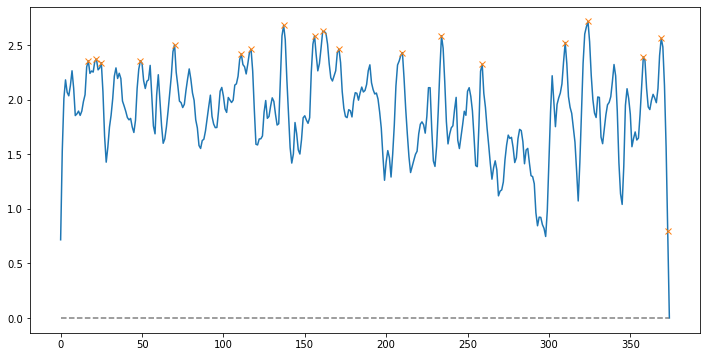

Peak count: 19
Frame tokens: ” 나도 따라갔다. 있었다. 그녀는 나는 즉 얼마쯤 말했다. 보게, 시대에 나는 있었다. 한 재산이었다. “가엾게도. 가게였다. 나는 들어갔다. 

Similarity : 0.42730590875527197
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.6884889602661133 Generator / grammar loss:-0.1796824187040329   similarity loss:-0.10790246725082397


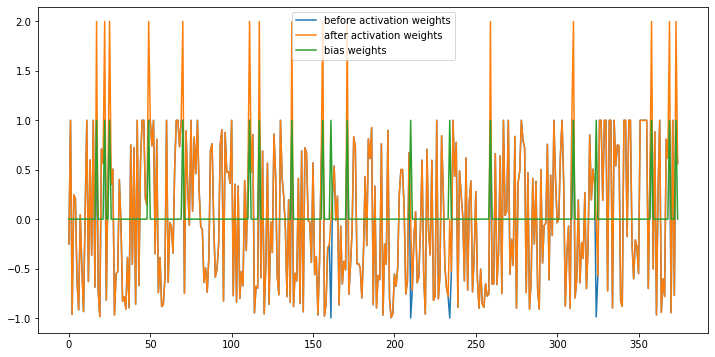

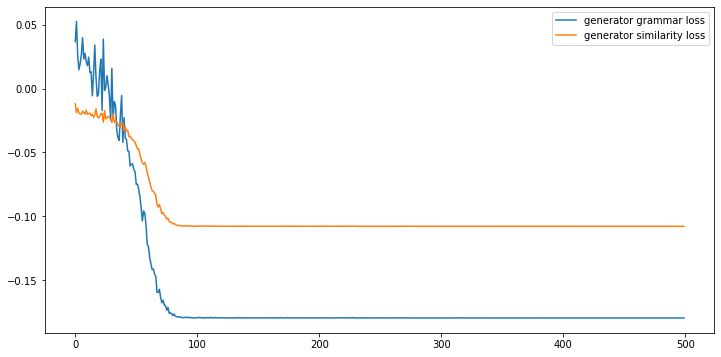

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
“그렇습니다. 저는 안 ” 나도 따라갔다. 거의 위에 사진이 있었다. 내가 들여다보자 한 메리 드로워의 사진이었다. 그녀는 얼굴에 있었다. 나이든 나는 즉 아주 얼마쯤 말했다. 시대에 떨었다. 빈방으로 한 한 종류, 싸구려 검은 것들이 남긴 재산이었다. 헤이스팅즈, 여기에는 아무것도 없네. 다른 길로 그는 애셔 부인의 맞은편에 야채 밖에 내놓은 물건이 더 많은 가게였다. 몇 나는 뒤 들어갔다.
--------------------------------------------------
     method  comp ratio     intro      body    ending       var     total  \
0  SAM+WGAN    0.148422  0.537609  0.460955  0.661766  0.006846  0.516142   

    grammar  
0  0.971094  
Current result ==================================================
Sample count: 25
     method  comp rate     intro      body  conclusion  isthmus  simlirality  \
0  SAM+WGAN   0.165177  0.544005  0.517303    0.552699  0.00413     0.533211   

   grammarity  
0    0.932216  
26 / 70
------------------------------------------------------------------
그는 막 상추를 사고 있는 중이었다. 나는 딸기를 1파운드 샀다. 포아로는 물건을 싸주는 뚱뚱한 아주머니

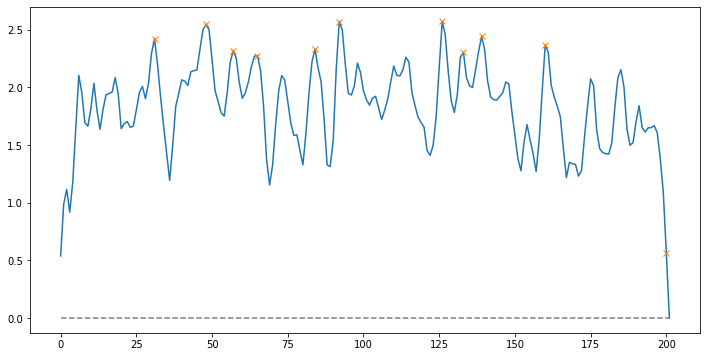

Peak count: 11
Frame tokens: 얼마나 모양이다. 대체 꽤 여자가 ” 비나가니까요. 그런 않는데요. 들었습니다만. 덧붙였다. 

Similarity : 0.3919513850202174
Train... |||||||||||||||||||||| 100.0%   500/500 epochs, beta:2.5769858360290527 Generator / grammar loss:-0.1876135915517807   similarity loss:-0.1282292902469635


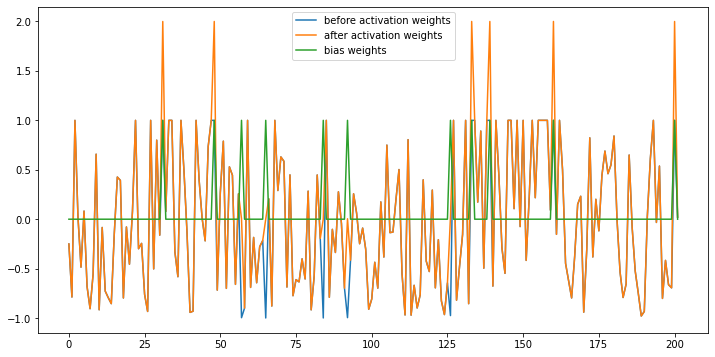

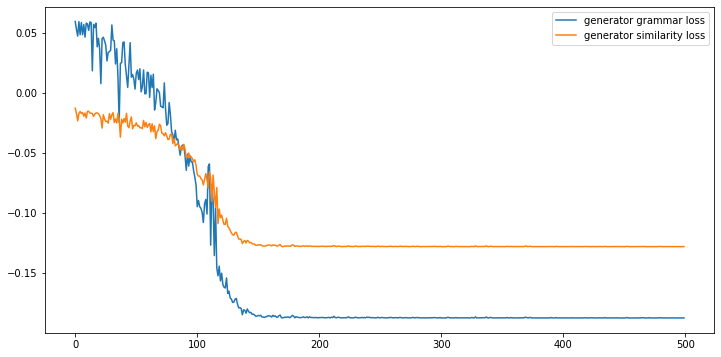

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
막 일어난 이런 얼마나 그 뚱뚱한 사건 같았다. 길었던 모양이다. 그렇게 범인이 날카롭게 키가 훌륭한 그런 사람이 생각되지 않는데요. 그래서 나는 포아로에게 “실례지만, 잘못 아닙니까? 작고 얼굴빛이 검은 남자라고 들었습니다만. 그리하여 남자를 덧붙였다.
--------------------------------------------------
     method  comp ratio     intro     body    ending      var     total  \
0  SAM+WGAN    0.164352  0.407234  0.34944  0.595227  0.01101  0.440306   

    grammar  
0  0.985559  
Current result ==================================================
Sample count: 26
     method  comp rate     intro      body  conclusion   isthmus  simlirality  \
0  SAM+WGAN   0.165145  0.538745  0.510847    0.554335  0.004394     0.529637   

   grammarity  
0    0.934267  
27 / 70
------------------------------------------------------------------
겨우 쇼핑이 끝나 우리는 거짓말을 한 채 그대로 가게를 나왔다. 나는 얼마쯤 비난을 섞어 물었다. “대체 그건 무슨 연극이었나, 포아로?” “나는 다만 낯선 사람이 저쪽 가게로 들어갔는지 어떤지 듣고 싶었던 것뿐일세. ” “그럼, 그렇게 물어보면 되

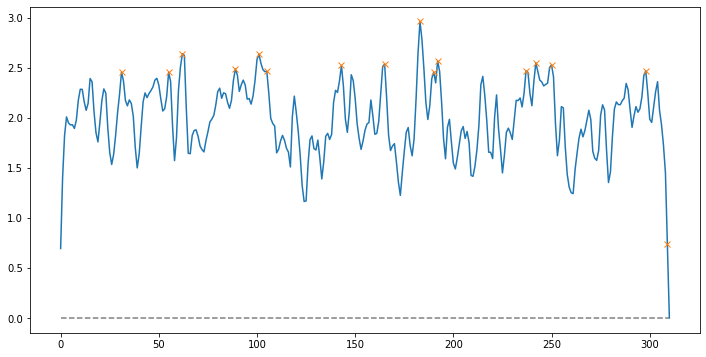

Peak count: 16
Frame tokens: 것뿐일세. 없다네. 질문에 버리지. 말이라도 풀려나온다네. 끊었다. 보게, 당황했다. 그 깜짝 말했다. 어쩌나. 모자라기 말했다. 말했다. 

Similarity : 0.4406176190958253
Train... ||||||||||||||||||||.| 95.0%   475/500 epochs, beta:2.33781099319458 Generator / grammar loss:-0.16352517902851105   similarity loss:-0.12941724061965942

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

test_result = {}
test_result['SAM+WGAN']=[]

step = 0
for intro,body,end in ko_docs:
    step += 1
    print("=" * 50)
    print(str(step),"/",len(ko_docs))
    print("=" * 50)
    
    org_text_1 = intro
    org_text_2 = body
    org_text_3 = end

    try:
        df1,dct1 = sam_wgan('',[org_text_1,org_text_2,org_text_3],init_bias=1.0,display= True)
        if dct1['grammar'][0] > 0.0:

            test_result['SAM+WGAN'].append(get_features(dct1))
            #result = pd.concat([df1, df2, df3, df4, df5, df6 ], ignore_index=True)
            #result = pd.concat([df1, df2, df3, df5, df6 ], ignore_index=True)
            
            print(df1)
            
            print("Current result","=" * 50)
            print("Sample count:",len(test_result['SAM+WGAN']))
            print(get_test_statistics(test_result))
        
    except KeyboardInterrupt as ki:
        raise ki
    except :
        print("Unexpected error:", sys.exc_info()[0])
        #raise e
        pass

get_test_statistics(test_result)

## Reference

[1] Rada Mihalcea and Paul Tarau, (2004). TextRank: Bringing Order into Texts <br>
[2] G¨une¸s Erkan. (2004). LexRank: Graph-based Lexical Centrality as Salience in Text Summarization <br>
[3] Susan T. Dumais (2005). "Latent Semantic Analysis". Annual Review of Information Science and Technology. 38: 188–230. <br>
[4] Hans Peter Luhn (1960). Keyword-in-context index for technical literature. American Documentation, 11(4):288–295. ISSN 0002-823 <br>
[5] Aria Haghighi, (2009). Exploring Content Models for Multi-Document Summarization <br>
[6] Colin Raffel. (2020). Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer <br>
[7] Mike Lewis, (2019). BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension <br>
[8] Alec Radford, (2018). Language Models are Unsupervised Multitask Learners <br>
[9] Guillaume Lample, (2019). Cross-lingual Language Model Pretraining <br>
[10] Nils Reimers and Iryna Gurevych, (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks <br>
[11] Sharma, P., & Li, Y. (2019). Self-Supervised Contextual Keyword and Keyphrase Retrieval with Self-Labelling <br>
[12] Jacob Devlin, (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding <br>
[13] Ian J. Goodfellow, (2014). Generative Adversarial Nets <br>
[14] Yau-ShianWang, (2018). Learning to Encode Text as Human-Readable Summaries using Generative Adversarial Networks <br>
[15] Martin Arjovsky, (2017). Wasserstein GAN <br>